# Main ML pipeline

In [91]:
from pandas.core.common import random_state
from qiskit.visualization import plot_histogram
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os
from scripts.ned_calculator import NedCalculator
import shutil
import seaborn as sns
from astropy.io import fits


In [92]:
results_summary = pd.DataFrame(columns=['name', 'features', 'test_r2', 'train_avg_r2', 'feature_importances'])

test_predictions = {}  # Format: {name: {ID: {seed: prediction}}}
train_predictions = {}  # Format: {name: {index: {seed: prediction}}}

def test_regression_on_INSPIRE(name, FEATURES,test_df, train_df,MODEL_PARAMS, plotting=False, random_state=1):
    
    # Extract features and target
    X_train = train_df[FEATURES]
    y_train = train_df['DoR']
    X_test = test_df[FEATURES]
    y_test = test_df['DoR']
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    # print("Training the model...")
    rf_model = RandomForestRegressor(**MODEL_PARAMS)
    rf_model.fit(X_train_scaled, y_train)
    
        # Get feature importances and store as dictionary
    feature_importance_dict = dict(zip(FEATURES, rf_model.feature_importances_))
    
    
    # Make predictions on test data
    # print("Making predictions on test data...")
    y_pred = rf_model.predict(X_test_scaled)

    if name not in test_predictions:
        test_predictions[name] = {}
    for idx, id_val in enumerate(test_df['ID_INSPIRE']):
        if id_val not in test_predictions[name]:
            test_predictions[name][id_val] = {}
        test_predictions[name][id_val][random_state] = y_pred[idx]
    
    # Calculate residuals
    residuals = y_test - y_pred
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # print(f"Test R²: {r2:.4f}")
    # print(f"Test RMSE: {rmse:.4f}")
    # print(f"Test MAE: {mae:.4f}")
    small_boundary = 0.35
    large_boundary = 0.6
    small_mask = y_pred <= small_boundary
    mid_mask = (y_pred > small_boundary) & (y_pred < large_boundary)
    large_mask = y_pred >= large_boundary
        
    small_rmse = np.sqrt(mean_squared_error(y_test[small_mask], y_pred[small_mask])) if np.any(small_mask) else np.nan
    mid_rmse = np.sqrt(mean_squared_error(y_test[mid_mask], y_pred[mid_mask])) if np.any(mid_mask) else np.nan
    large_rmse = np.sqrt(mean_squared_error(y_test[large_mask], y_pred[large_mask])) if np.any(large_mask) else np.nan
        
    
    if plotting:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 16), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.05})
        
        # Plot settings
        plt.rcParams.update({
            "text.usetex": True,
            "font.family": "Computer Modern",
            "figure.dpi": 300,
            "font.size": 20,
        })
        
        SNR_values = test_df['SNR_MEAN']

        # ax1.scatter(y_pred, y_test, alpha=0.7, s=35, color='royalblue', edgecolors='k', linewidths=0.5)
        scatter = ax1.scatter(y_pred, y_test, alpha=0.7, s=35, c=SNR_values, 
                         cmap='viridis', edgecolors='k', linewidths=0.5)
        
        min_val = min(min(y_test), min(y_pred))
        max_val = max(max(y_test), max(y_pred))
        buffer = (max_val - min_val) * 0.02
        plot_min = min_val - buffer
        plot_max = max_val + buffer
        
        ax1.plot([plot_min, plot_max], [plot_min, plot_max], 'r--', 
                label='Perfect prediction', linewidth=1.5)
    
        
        ax1.set_ylabel('True DoR', fontsize=20)
        ax1.set_xlim(plot_min, plot_max)
        ax1.set_ylim(plot_min, plot_max)

        
        # Add textbox with performance metrics to top plot
        props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='lightgray')
        textstr = '\n'.join((
            r'$\mathrm{R}^2 = %.4f$' % (r2,),
            r'$\mathrm{RMSE} = %.4f$' % (rmse,),
        ))
        ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=20,
                verticalalignment='top', bbox=props)
        
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='both', which='both', direction='in', labelsize=14)
        ax1.minorticks_on()
        for spine in ax1.spines.values():
            spine.set_color('lightgray')
        
        # ax2.scatter(y_pred, residuals, alpha=0.7, s=35, color='royalblue', edgecolors='k', linewidths=0.5)
        ax2.scatter(y_pred, residuals, alpha=0.7, s=35, c=SNR_values, 
                    cmap='viridis', edgecolors='k', linewidths=0.5)
        ax2.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
        
        
        ax2.set_xlabel('Predicted DoR', fontsize=20)
        ax2.set_ylabel('Residuals (True - Predicted)', fontsize=20)
        
                
        cbar = fig.colorbar(scatter, ax=ax2)
        cbar.set_label('SNR', rotation=270, labelpad=15, fontsize=20)
        
        #cbar = fig.colorbar(scatter, ax=ax2, orientation='horizontal', pad=0.15)
        #cbar.set_label('SNR', fontsize=20)
        
        # Add textbox with region-specific RMSE to bottom plot
        props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='lightgray')
        textstr = '\n'.join((
            r'$\mathrm{Overall\ RMSE} = %.4f$' % (rmse,),
            r'$\mathrm{RMSE\ (DoR \leq %.2f)} = %.4f$' % (small_boundary, small_rmse),
            r'$\mathrm{RMSE\ (%.2f < DoR < %.2f)} = %.4f$' % (small_boundary, large_boundary, mid_rmse),
            r'$\mathrm{RMSE\ (DoR \geq %.2f)} = %.4f$' % (large_boundary, large_rmse)
        ))
        ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=20,
                verticalalignment='top', bbox=props)
        
        # Add grid and styling to bottom plot
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='both', which='both', direction='in', labelsize=14)
        ax2.minorticks_on()
        for spine in ax2.spines.values():
            spine.set_color('lightgray')
        
        plt.tight_layout()
        plt.savefig('tests/'+name+'_test.pdf', bbox_inches='tight')
        # plt.show()
    
    # print(f"\nRegion-specific RMSE:")
    # print(f"RMSE (DoR ≤ {small_boundary}): {small_rmse:.4f}")
    # print(f"RMSE ({small_boundary} < DoR < {large_boundary}): {mid_rmse:.4f}")
    # print(f"RMSE (DoR ≥ {large_boundary}): {large_rmse:.4f}")
    
    inspection_df = pd.DataFrame({
    'Index': test_df.index,
    'True_DoR': y_test,
    'Predicted_DoR': y_pred,
    'ID': test_df['ID_INSPIRE']
    })

    inspection_df['absolute_residual'] = abs(inspection_df['True_DoR'] - inspection_df['Predicted_DoR'])
    inspection_df = inspection_df.sort_values('absolute_residual', ascending=False)
    #print("Largest absolute residuals:")
    #print(inspection_df.head(5)) # len(inspection_df)))

    global results_summary
    results_summary = pd.concat([results_summary, pd.DataFrame({
        'name': [name],
        'features': [', '.join(FEATURES)],
        'test_r2': [r2],
        'train_avg_r2': [None],  # Will be filled in by visualize_kfold_predictions_training
        'feature_importances': [feature_importance_dict],
        'random_seed': [random_state]  # Add random_state to track different runs
    })], ignore_index=True)
    
    visualize_kfold_predictions_training(train_df, FEATURES, name, model_params=MODEL_PARAMS, plotting=plotting)

def visualize_kfold_predictions_training(df, features, name, target='DoR', n_splits=5, model_params=None, 
                                 small_boundary=0.35, large_boundary=0.6, plotting=False):
    # print(model_params)
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 20,
    })
    
    X = df[features]
    y = df[target]
    
    # Set up K-Fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=model_params['random_state'])
    
    # Initialize arrays to store all predictions
    all_true = np.zeros_like(y)
    all_pred = np.zeros_like(y)
    all_residuals = np.zeros_like(y)
    fold_indices = np.zeros_like(y, dtype=int)  # Track which fold each point belongs to
    fold_results = {
        'r2_scores': [],
        'indices': [],
        'predictions': [],
        'true_values': [],
    }
    
    # Define colors for different folds
    fold_colors = plt.cm.tab10(np.linspace(0, 1, n_splits))
    
    # Perform k-fold cross-validation
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Split and scale data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model and make predictions
        rf_model = RandomForestRegressor(**model_params)
        rf_model.fit(X_train_scaled, y_train)
        y_pred = rf_model.predict(X_test_scaled)
        
        if name not in train_predictions:
            train_predictions[name] = {}
        for idx, pred_val in zip(test_idx, y_pred):
            if idx not in train_predictions[name]:
                train_predictions[name][idx] = {}
            train_predictions[name][idx][model_params['random_state']] = pred_val
        
        # Store results for this fold
        r2 = r2_score(y_test, y_pred)
        fold_results['r2_scores'].append(r2)
        fold_results['indices'].append(test_idx)
        fold_results['predictions'].append(y_pred)
        fold_results['true_values'].append(y_test.values)
        
        # Store predictions and residuals at the correct indices
        all_true[test_idx] = y_test
        all_pred[test_idx] = y_pred
        all_residuals[test_idx] = y_test - y_pred
        fold_indices[test_idx] = fold  # Track which fold this point belongs to
        
        # print(f"Fold {fold}/{n_splits} - R²: {r2:.4f}")
    
    # Calculate overall R² for all folds combined
    overall_r2 = r2_score(all_true, all_pred)
    mean_fold_r2 = np.mean(fold_results['r2_scores'])
    std_fold_r2 = np.std(fold_results['r2_scores'])
    
    mask = (results_summary['name'] == name) & (results_summary['random_seed'] == model_params['random_state'])
    results_summary.loc[mask, 'train_avg_r2'] = mean_fold_r2
    
    # Calculate overall RMSE and MAE
    rmse = np.sqrt(mean_squared_error(all_true, all_pred))
    mae = mean_absolute_error(all_true, all_pred)
    
    # print(f"\nCross-validation results:")
    # print(f"Mean fold R²: {mean_fold_r2:.4f} (±{std_fold_r2:.4f})")
    # print(f"Overall R² (all predictions): {overall_r2:.4f}")
    # print(f"Overall RMSE: {rmse:.4f}")
    # print(f"Overall MAE: {mae:.4f}")
    
    if plotting:
        # Create figure with two subplots sharing x-axis
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 16), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.05})
        
        # Find plot limits
        min_val = min(min(all_true), min(all_pred))
        max_val = max(max(all_true), max(all_pred))
        buffer = (max_val - min_val) * 0.02
        plot_min = min_val - buffer
        plot_max = max_val + buffer
        
        # Top subplot: True vs Predicted
        # Plot each fold with different colors - x=predicted, y=true
        for fold in range(1, n_splits + 1):
            mask = fold_indices == fold
            ax1.scatter(all_pred[mask], all_true[mask], alpha=0.7, s=35,
                       color=fold_colors[fold - 1], edgecolors='k', linewidths=0.5,
                       label=f'Fold {fold} (R²: {fold_results["r2_scores"][fold - 1]:.4f})')
        
        # Add perfect prediction line
        ax1.plot([plot_min, plot_max], [plot_min, plot_max], 'r--',
                 label='Perfect prediction', linewidth=1.5)
        
        # Customize top plot
        ax1.set_ylabel('True DoR', fontsize=20)
        ax1.set_xlim(plot_min, plot_max)
        ax1.set_ylim(plot_min, plot_max)
        
        # Add textbox with performance metrics for top plot
        props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='lightgray')
        textstr = '\n'.join((
            r'$\mathrm{Mean}\ R^2 = %.4f\ (\pm%.4f)$' % (mean_fold_r2, std_fold_r2),
        ))
        ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=20,
                 verticalalignment='top', bbox=props)
        
        ax1.legend(loc='lower right', fontsize=20)
        
        # Add grid and styling to top plot
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='both', which='both', direction='in', labelsize=14)
        ax1.minorticks_on()
        for spine in ax1.spines.values():
            spine.set_color('lightgray')
        
        # Bottom subplot: Residuals vs Predicted
        for fold in range(1, n_splits + 1):
            mask = fold_indices == fold
            ax2.scatter(all_pred[mask], all_residuals[mask], alpha=0.7, s=35,
                       color=fold_colors[fold - 1], edgecolors='k', linewidths=0.5,
                       label=f'Fold {fold}')
        
        ax2.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
        
        # Calculate region-specific RMSE by predicted DoR
        small_mask = all_pred <= small_boundary
        mid_mask = (all_pred > small_boundary) & (all_pred < large_boundary)
        large_mask = all_pred >= large_boundary
        
        small_rmse = np.sqrt(mean_squared_error(all_true[small_mask], all_pred[small_mask])) if np.any(small_mask) else np.nan
        mid_rmse = np.sqrt(mean_squared_error(all_true[mid_mask], all_pred[mid_mask])) if np.any(mid_mask) else np.nan
        large_rmse = np.sqrt(mean_squared_error(all_true[large_mask], all_pred[large_mask])) if np.any(large_mask) else np.nan
        
        # Customize bottom plot
        ax2.set_xlabel('Predicted DoR', fontsize=20)
        ax2.set_ylabel('Residuals (True - Predicted)', fontsize=20)
        
        # Add region-specific metrics in a textbox for bottom plot
        props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='lightgray')
        textstr = '\n'.join((
            r'$\mathrm{Overall\ RMSE} = %.4f$' % (rmse,),
            r'$\mathrm{RMSE\ (DoR \leq %.2f)} = %.4f$' % (small_boundary, small_rmse),
            r'$\mathrm{RMSE\ (%.2f < DoR < %.2f)} = %.4f$' % (small_boundary, large_boundary, mid_rmse),
            r'$\mathrm{RMSE\ (DoR \geq %.2f)} = %.4f$' % (large_boundary, large_rmse)
        ))
        ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=20,
                verticalalignment='top', bbox=props)
        
        # Add grid and styling to bottom plot
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='both', which='both', direction='in', labelsize=14)
        ax2.minorticks_on()
        for spine in ax2.spines.values():
            spine.set_color('lightgray')
        
        plt.tight_layout()
        plt.savefig('tests/'+name+'_train_cv.pdf', bbox_inches='tight')
        # plt.show()
    
        return fig

def visualize_ensemble_predictions_combined_residuals_DO_NOT_USE(model_name):
    
    top = 0.9
    bottom = 0
    # Check if predictions exist for this model
    if model_name not in test_predictions:
        print(f"No test predictions found for model: {model_name}")
        return
    
    if model_name not in train_predictions:
        print(f"No train predictions found for model: {model_name}")
        return
    
    # Set plotting style
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 26,
    })
    
    # Create figure with 2x2 grid
    fig = plt.figure(figsize=(12, 12))
    
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], 
                          hspace=0.0, wspace=0.0)
    
    # Create top-left subplot for train (swapped from original)
    ax_train = fig.add_subplot(gs[0, 0])
    
    # Top-right for test, shares y-axis with top-left
    ax_test = fig.add_subplot(gs[0, 1], sharey=ax_train)
    
    # Bottom-left for train residuals, shares x with top-left
    ax_train_res = fig.add_subplot(gs[1, 0], sharex=ax_train) # , sharey=ax_train)
    
    # Bottom-right for test residuals, shares x with top-right and y with bottom-left
    ax_test_res = fig.add_subplot(gs[1, 1], sharex=ax_test, sharey=ax_train_res)

    plt.setp(ax_test.get_yticklabels(), visible=False)        # top right y-ticks
    plt.setp(ax_test.get_xticklabels(), visible=False)        # top right x-ticks
    plt.setp(ax_train.get_xticklabels(), visible=False)       # top left x-ticks
    plt.setp(ax_test_res.get_yticklabels(), visible=False)    # bottom right y-ticks

    # Process and plot each dataset - train first, then test (swapped order)
    datasets = [
        {"name": "train", "ax": ax_train, "ax_res": ax_train_res, 
         "predictions": train_predictions, "df": train_df, "id_field": None},
        {"name": "test", "ax": ax_test, "ax_res": ax_test_res, 
         "predictions": test_predictions, "df": test_df, "id_field": "ID_INSPIRE"}
    ]
    
    all_snr_values = []  # Collect all SNR values for shared colorbar
    scatter_artists = []  # Save scatter artists for colorbar
    
    for dataset in datasets:
        # Get data points
        predictions_dict = dataset["predictions"]
        df = dataset["df"]
        data_points = list(predictions_dict[model_name].keys())
        
        # Create mappings from data points to true values and SNR
        if dataset["id_field"] is not None:  # Test data
            point_to_true = {id_val: df.loc[df[dataset["id_field"]] == id_val, 'DoR'].values[0] 
                             for id_val in data_points}
            point_to_snr = {id_val: df.loc[df[dataset["id_field"]] == id_val, 'SNR'].values[0] 
                            for id_val in data_points}
        else:  # Train data
            point_to_true = {idx: df.loc[idx, 'DoR'] for idx in data_points}
            point_to_snr = {idx: df.loc[idx, 'SNR'] for idx in data_points}
        
        # Calculate average and std of predictions
        y_true = []
        y_pred_avg = []
        y_pred_std = []
        snr_values = []
        
        for id_val in data_points:
            predictions = list(predictions_dict[model_name][id_val].values())
            if predictions and id_val in point_to_true and id_val in point_to_snr:
                y_true.append(point_to_true[id_val])
                y_pred_avg.append(np.mean(predictions))
                y_pred_std.append(np.std(predictions))
                snr_values.append(point_to_snr[id_val])
        
        # Convert to numpy arrays for calculations
        y_true = np.array(y_true)
        y_pred_avg = np.array(y_pred_avg)
        y_pred_std = np.array(y_pred_std)
        snr_values = np.array(snr_values)
        
        # Add to overall SNR values for colorbar
        all_snr_values.extend(snr_values)
        
        # Remove NaN values
        valid_indices = ~np.isnan(y_pred_avg) & ~np.isnan(snr_values)
        if np.sum(valid_indices) < 10:  # Require at least 10 valid points
            print(f"Not enough valid predictions for {dataset['name']} data in model: {model_name}")
            continue
        
        y_true = y_true[valid_indices]
        y_pred_avg = y_pred_avg[valid_indices]
        y_pred_std = y_pred_std[valid_indices]
        snr_values = snr_values[valid_indices]
        
        """seed_r2_scores = {}
        for id_val in data_points:
            if id_val in point_to_true:
                true_val = point_to_true[id_val]
                # Group predictions by seed
                for seed, pred in predictions_dict[model_name][id_val].items():
                    if seed not in seed_r2_scores:
                        seed_r2_scores[seed] = {'true': [], 'pred': []}
                    seed_r2_scores[seed]['true'].append(true_val)
                    seed_r2_scores[seed]['pred'].append(pred)
        
        # Calculate R² for each seed, then average
        individual_r2_scores = []
        for seed, values in seed_r2_scores.items():
            if len(values['true']) > 1:  # Need at least 2 points to calculate R²
                seed_r2 = r2_score(values['true'], values['pred'])
                individual_r2_scores.append(seed_r2)
        
        r2 = np.mean(individual_r2_scores) if individual_r2_scores else 0
        rmse = np.sqrt(mean_squared_error(y_true, y_pred_avg))"""
        
        r2 = r2_score(y_true, y_pred_avg)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred_avg))
        
        # Plot True vs Predicted with SNR coloring
        ax = dataset["ax"]
        # scatter = ax.scatter(y_pred_avg, y_true, c=snr_values, cmap='viridis', s=50, alpha=0.7, edgecolors='none')
        
        low = 20
        high = 70
        snr_categories = np.zeros_like(snr_values, dtype=int)
        snr_categories[(snr_values >= low) & (snr_values < high)] = 1  # Medium SNR
        snr_categories[snr_values >= high] = 2  # High SNR
        
        category_colors = ['#d53e4f', '#fee08b','#3288bd']  # Blue, Yellow, Red for Low, Medium, High
        point_colors = [category_colors[cat] for cat in snr_categories]
        
        # Replace the scatter plot lines with this:
        scatter = ax.scatter(y_pred_avg, y_true, c=point_colors, s=50, alpha=0.7, edgecolors='none')
        
        scatter_artists.append(scatter)
        
        # Draw error bars using errorbar function with no markers
        ax.errorbar(y_pred_avg, y_true, xerr=y_pred_std, fmt='none', ecolor='#000000', 
                   elinewidth=0.2, capsize=0)
        
        ax.set_xlim(bottom, top)
        ax.set_ylim(bottom, top)
        
        # Create consistent tick marks with 0.1 increments
        ticks = np.arange(0.1, 1, 0.2)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels([f'{t:.1f}' for t in ticks])
        ax.set_yticklabels([f'{t:.1f}' for t in ticks])
        
        # Add perfect prediction line
        ax.plot([0.0, 1], [0.0, 1], 'r--', 
               label='Perfect prediction', linewidth=1.5)
        
        # Add annotations
        props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='lightgray')
        
        textstr = '\n'.join((
            r'$\mathrm{%s}$' % (dataset["name"].capitalize(),),
            r'$\mathrm{R}^2 = %.4f$' % (r2,),
            r'$\mathrm{RMSE} = %.4f$' % (rmse,),
        ))
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=20,
               verticalalignment='top', bbox=props)
        
        # Style plot
        ax.set_ylabel('True DoR', fontsize=20)
        if dataset["name"] == "test":
            ax.set_ylabel('')  # Remove label for test (right side)
        
        # ax.set_xlabel('Predicted DoR', fontsize=20)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
        ax.minorticks_on()
        
        # Plot residuals
        ax_res = dataset["ax_res"]
        residuals = y_true - y_pred_avg
        #scatter_res = ax_res.scatter(y_pred_avg, residuals, c=snr_values, cmap='viridis',s=50, alpha=0.7, edgecolors='none')
        scatter_res = ax_res.scatter(y_pred_avg, residuals, c=point_colors, s=50, alpha=0.7, edgecolors='none')

        # Draw error bars for residuals
        ax_res.errorbar(y_pred_avg, residuals, xerr=y_pred_std, fmt='none', ecolor='#000000', 
                       elinewidth=0.2, capsize=0)
        
        ax_res.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
        
        # Set limits for residuals
        residual_max = max(abs(np.min(residuals)), abs(np.max(residuals)))
        residual_limit = min(0.5, np.ceil(residual_max * 10) / 10)  # Round up to nearest 0.1
        ax_res.set_ylim(-residual_limit, residual_limit)
        
        # Create even tick marks for residuals
        residual_ticks = np.arange(-residual_limit, residual_limit + 0.1, 0.1).round(1)
        ax_res.set_yticks(residual_ticks)
        ax_res.set_yticklabels([f'{t:.1f}' for t in residual_ticks])
        
        # Keep consistent x-ticks
        ax_res.set_xlim(bottom, top)
        ax_res.set_xticks(ticks)
        ax_res.set_xticklabels([f'{t:.1f}' for t in ticks])
        
        # Style residual plot
        ax_res.set_xlabel('Predicted DoR', fontsize=20)
        ax_res.set_ylabel('Residuals', fontsize=20)
        if dataset["name"] == "test":
            ax_res.set_ylabel('')  # Remove label for test (right side)
        
        ax_res.grid(True, alpha=0.3)
        ax_res.tick_params(axis='both', which='both', direction='in', labelsize=12)
        ax_res.minorticks_on()
        
    yticks = ax_train_res.get_yticks()
    yticklabels = ax_train_res.get_yticklabels()
    if len(yticklabels) > 0:
        yticklabels[-1].set_visible(False)  # Hide the last (rightmost) tick label
        
    ax_test_res.set_xlabel('Predicted DoR', fontsize=20)
    ax_train_res.set_xlabel('Predicted DoR', fontsize=20)
    
    # Add a single colorbar to the right of the figure
    """cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    all_snr_values = np.array(all_snr_values)
    norm = plt.Normalize(vmin=min(all_snr_values), vmax=max(all_snr_values))
    sm = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('SNR', rotation=270, labelpad=15, fontsize=20)"""

    from matplotlib.patches import Patch
    legend_elements = [
    Patch(facecolor=category_colors[0], edgecolor='none', alpha=0.7, label=r'$\mathrm{SNR} < 20$'),
    Patch(facecolor=category_colors[1], edgecolor='none', alpha=0.7, label=r'$20 \leq \mathrm{SNR} < 70$'),
    Patch(facecolor=category_colors[2], edgecolor='none', alpha=0.7, label=r'$\mathrm{SNR} \geq 70$')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.08),
          ncol=3, frameon=True, fontsize=20, title='SNR Categories')
    
    # plt.show()
    plt.savefig(f'../outputs/tests/{model_name}_combined_ensemble.pdf', bbox_inches='tight')
    plt.close()
    
    return True

"""def visualize_ensemble_predictions_combined(model_name):
    
    top = 0.9
    bottom = 0
    # Check if predictions exist for this model
    if model_name not in test_predictions:
        print(f"No test predictions found for model: {model_name}")
        return
    
    if model_name not in train_predictions:
        print(f"No train predictions found for model: {model_name}")
        return
    
    # Set plotting style
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 26,
    })
    
    # Create figure with 2x1 grid (train on top, test on bottom)
    fig = plt.figure(figsize=(10, 18))
    
    # Create gridspec with 2 rows, 1 column
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 1], 
                          hspace=0.1)
    
    # Create plots - train on top, test on bottom
    ax_train = fig.add_subplot(gs[0, 0])
    ax_test = fig.add_subplot(gs[1, 0], sharex=ax_train)

    # Process and plot each dataset - train first, then test
    datasets = [
        {"name": "train", "ax": ax_train, "predictions": train_predictions, 
         "df": train_df, "id_field": None},
        {"name": "test", "ax": ax_test, "predictions": test_predictions, 
         "df": test_df, "id_field": "ID_INSPIRE"}
    ]
    
    all_snr_values = []  # Collect all SNR values for shared colorbar
    scatter_artists = []  # Save scatter artists for colorbar
    
    for dataset in datasets:
        # Get data points
        predictions_dict = dataset["predictions"]
        df = dataset["df"]
        data_points = list(predictions_dict[model_name].keys())
        
        # Create mappings from data points to true values and SNR
        if dataset["id_field"] is not None:  # Test data
            point_to_true = {id_val: df.loc[df[dataset["id_field"]] == id_val, 'DoR'].values[0] 
                             for id_val in data_points}
            point_to_snr = {id_val: df.loc[df[dataset["id_field"]] == id_val, 'SNR'].values[0] 
                            for id_val in data_points}
        else:  # Train data
            point_to_true = {idx: df.loc[idx, 'DoR'] for idx in data_points}
            point_to_snr = {idx: df.loc[idx, 'SNR'] for idx in data_points}
        
        # Calculate average and std of predictions
        y_true = []
        y_pred_avg = []
        y_pred_std = []
        snr_values = []
        
        for id_val in data_points:
            predictions = list(predictions_dict[model_name][id_val].values())
            if predictions and id_val in point_to_true and id_val in point_to_snr:
                y_true.append(point_to_true[id_val])
                y_pred_avg.append(np.mean(predictions))
                y_pred_std.append(np.std(predictions))
                snr_values.append(point_to_snr[id_val])
        
        # Convert to numpy arrays for calculations
        y_true = np.array(y_true)
        y_pred_avg = np.array(y_pred_avg)
        y_pred_std = np.array(y_pred_std)
        snr_values = np.array(snr_values)
        
        # Add to overall SNR values for colorbar
        all_snr_values.extend(snr_values)
        
        # Remove NaN values
        valid_indices = ~np.isnan(y_pred_avg) & ~np.isnan(snr_values)
        if np.sum(valid_indices) < 10:  # Require at least 10 valid points
            print(f"Not enough valid predictions for {dataset['name']} data in model: {model_name}")
            continue
        
        y_true = y_true[valid_indices]
        y_pred_avg = y_pred_avg[valid_indices]
        y_pred_std = y_pred_std[valid_indices]
        snr_values = snr_values[valid_indices]
        # Calculate metrics the right way - using sklearn's r2_score for each seed separately
        seed_r2_scores = {}
        for id_val in data_points:
            if id_val in point_to_true:
                true_val = point_to_true[id_val]
                # Group predictions by seed
                for seed, pred in predictions_dict[model_name][id_val].items():
                    if seed not in seed_r2_scores:
                        seed_r2_scores[seed] = {'true': [], 'pred': []}
                    seed_r2_scores[seed]['true'].append(true_val)
                    seed_r2_scores[seed]['pred'].append(pred)
        
        # Calculate R² for each seed, then average
        individual_r2_scores = []
        for seed, values in seed_r2_scores.items():
            if len(values['true']) > 1:  # Need at least 2 points to calculate R²
                seed_r2 = r2_score(values['true'], values['pred'])
                individual_r2_scores.append(seed_r2)
        
        r2 = np.mean(individual_r2_scores) if individual_r2_scores else 0
        rmse = np.sqrt(mean_squared_error(y_true, y_pred_avg))

        # Calculate metrics
        #r2 = r2_score(y_true, y_pred_avg)
        #rmse = np.sqrt(mean_squared_error(y_true, y_pred_avg))
        
        # Plot True vs Predicted with SNR coloring
        ax = dataset["ax"]
        
        low = 20
        high = 70
        snr_categories = np.zeros_like(snr_values, dtype=int)
        snr_categories[(snr_values >= low) & (snr_values < high)] = 1  # Medium SNR
        snr_categories[snr_values >= high] = 2  # High SNR
        
        category_colors = ['#d53e4f', '#fee08b','#3288bd']  # Blue, Yellow, Red for Low, Medium, High
        point_colors = [category_colors[cat] for cat in snr_categories]
        
        # Create scatter plot
        scatter = ax.scatter(y_pred_avg, y_true, c=point_colors, s=50, alpha=0.7, edgecolors='none')
        scatter_artists.append(scatter)
        
        # Draw error bars using errorbar function with no markers
        ax.errorbar(y_pred_avg, y_true, xerr=y_pred_std, fmt='none', ecolor='#000000', 
                   elinewidth=0.2, capsize=0)
        
        ax.set_xlim(bottom, top)
        ax.set_ylim(bottom, top)
        
        # Create consistent tick marks with 0.1 increments
        ticks = np.arange(0.1, 1, 0.2)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels([f'{t:.1f}' for t in ticks])
        ax.set_yticklabels([f'{t:.1f}' for t in ticks])
        
        # Add perfect prediction line
        ax.plot([0.0, 1], [0.0, 1], 'r--', 
               label='Perfect prediction', linewidth=1.5)
        
        # Add annotations
        props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='lightgray')
        textstr = '\n'.join((
            r'$\mathrm{%s}$' % (dataset["name"].capitalize(),),
            r'$\mathrm{R}^2 = %.4f$' % (r2,),
            r'$\mathrm{RMSE} = %.4f$' % (rmse,),
        ))
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=20,
               verticalalignment='top', bbox=props)
        
        # Style plot
        ax.set_ylabel('True DoR', fontsize=20)
        
        # Only add x-label to the bottom plot
        if dataset["name"] == "test":
            ax.set_xlabel('Predicted DoR', fontsize=20)
        else:
            # Hide x-tick labels for top plot
            ax.set_xticklabels([])
            plt.setp(ax.get_xticklabels(), visible=False)
        
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
        ax.minorticks_on()
    
    # Add a legend for SNR categories at the bottom of the figure
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=category_colors[0], edgecolor='none', alpha=0.7, label=r'$\mathrm{SNR} < 20$'),
        Patch(facecolor=category_colors[1], edgecolor='none', alpha=0.7, label=r'$20 \leq \mathrm{SNR} < 70$'),
        Patch(facecolor=category_colors[2], edgecolor='none', alpha=0.7, label=r'$\mathrm{SNR} \geq 70$')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.08),
          ncol=3, frameon=True, fontsize=20, title='SNR Categories')
    
    plt.savefig(f'../outputs/tests/{model_name}_combined_ensemble.pdf', bbox_inches='tight')
    plt.close()
    
    return True
"""

def visualize_ensemble_predictions_combined(model_name):
    
    top = 0.9
    bottom = 0
    
    # Use exact values from results_summary
    model_results = results_summary[results_summary['name'] == model_name]
    if len(model_results) > 0:
        # Round to 2 decimal places to match CSV format
        test_r2_value = round(model_results['test_r2'].mean(), 3)
        train_r2_value = round(model_results['train_avg_r2'].mean(), 3)
    else:
        print(f"Model {model_name} not found in results_summary")
        return False
    
    # Set plotting style
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 26,
    })
    
    # Create figure with 2x1 grid (train on top, test on bottom)
    fig = plt.figure(figsize=(10, 18))
    
    # Create gridspec with 2 rows, 1 column
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 1], 
                          hspace=0.1)
    
    # Create plots - train on top, test on bottom
    ax_train = fig.add_subplot(gs[0, 0])
    ax_test = fig.add_subplot(gs[1, 0], sharex=ax_train)

    # Process and plot each dataset - train first, then test
    datasets = [
        {"name": "train", "ax": ax_train, "predictions": train_predictions, 
         "df": train_df, "id_field": None},
        {"name": "test", "ax": ax_test, "predictions": test_predictions, 
         "df": test_df, "id_field": "ID_INSPIRE"}
    ]
    
    all_snr_values = []  # Collect all SNR values for shared colorbar
    scatter_artists = []  # Save scatter artists for colorbar
    
    for dataset in datasets:
        # Get data points
        predictions_dict = dataset["predictions"]
        df = dataset["df"]
        data_points = list(predictions_dict[model_name].keys())
        
        # Create mappings from data points to true values and SNR
        if dataset["id_field"] is not None:  # Test data
            point_to_true = {id_val: df.loc[df[dataset["id_field"]] == id_val, 'DoR'].values[0] 
                             for id_val in data_points}
            point_to_snr = {id_val: df.loc[df[dataset["id_field"]] == id_val, 'SNR'].values[0] 
                            for id_val in data_points}
        else:  # Train data
            point_to_true = {idx: df.loc[idx, 'DoR'] for idx in data_points}
            point_to_snr = {idx: df.loc[idx, 'SNR'] for idx in data_points}
        
        # Calculate average and std of predictions
        y_true = []
        y_pred_avg = []
        y_pred_std = []
        snr_values = []
        
        for id_val in data_points:
            predictions = list(predictions_dict[model_name][id_val].values())
            if predictions and id_val in point_to_true and id_val in point_to_snr:
                y_true.append(point_to_true[id_val])
                y_pred_avg.append(np.mean(predictions))
                y_pred_std.append(np.std(predictions))
                snr_values.append(point_to_snr[id_val])
        
        # Convert to numpy arrays for calculations
        y_true = np.array(y_true)
        y_pred_avg = np.array(y_pred_avg)
        y_pred_std = np.array(y_pred_std)
        snr_values = np.array(snr_values)
        
        # Add to overall SNR values for colorbar
        all_snr_values.extend(snr_values)
        
        # Remove NaN values
        valid_indices = ~np.isnan(y_pred_avg) & ~np.isnan(snr_values)
        if np.sum(valid_indices) < 10:  # Require at least 10 valid points
            print(f"Not enough valid predictions for {dataset['name']} data in model: {model_name}")
            continue
        
        y_true = y_true[valid_indices]
        y_pred_avg = y_pred_avg[valid_indices]
        y_pred_std = y_pred_std[valid_indices]
        snr_values = snr_values[valid_indices]
        
        # Calculate RMSE only (R² comes from results_summary)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred_avg))
        # Round RMSE to 2 decimal places
        rmse = round(rmse, 3)
        
        # Use the exact R² values from results_summary
        r2 = train_r2_value if dataset["name"] == "train" else test_r2_value
        
        # Plot True vs Predicted with SNR coloring
        ax = dataset["ax"]
        
        low = 20
        high = 70
        snr_categories = np.zeros_like(snr_values, dtype=int)
        snr_categories[(snr_values >= low) & (snr_values < high)] = 1  # Medium SNR
        snr_categories[snr_values >= high] = 2  # High SNR
        
        category_colors = ['#d53e4f', '#fee08b','#3288bd']  # Blue, Yellow, Red for Low, Medium, High
        point_colors = [category_colors[cat] for cat in snr_categories]
        
        # Create scatter plot
        scatter = ax.scatter(y_pred_avg, y_true, c=point_colors, s=50, alpha=0.7, edgecolors='none')
        scatter_artists.append(scatter)
        
        # Draw error bars using errorbar function with no markers
        ax.errorbar(y_pred_avg, y_true, xerr=y_pred_std, fmt='none', ecolor='#000000', 
                   elinewidth=0.2, capsize=0)
        
        ax.set_xlim(bottom, top)
        ax.set_ylim(bottom, top)
        
        # Create consistent tick marks with 0.1 increments
        ticks = np.arange(0.1, 1, 0.2)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels([f'{t:.1f}' for t in ticks])
        ax.set_yticklabels([f'{t:.1f}' for t in ticks])
        
        # Add perfect prediction line
        ax.plot([0.0, 1], [0.0, 1], 'r--', 
               label='Perfect prediction', linewidth=1.5)
        
        # Add annotations
        props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='lightgray')
            
        textstr = '\n'.join((
                r'$\mathrm{%s}$' % (dataset["name"].capitalize(),),
                r'$\mathrm{R}^2 = %.3f$' % (r2,),  
                r'$\mathrm{RMSE} = %.3f$' % (rmse,),
            ))

        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=20,
               verticalalignment='top', bbox=props)
        
        # Style plot
        ax.set_ylabel('True DoR', fontsize=20)
        
        # Only add x-label to the bottom plot
        if dataset["name"] == "test":
            ax.set_xlabel('Predicted DoR', fontsize=20)
        else:
            # Hide x-tick labels for top plot
            ax.set_xticklabels([])
            plt.setp(ax.get_xticklabels(), visible=False)
        
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
        ax.minorticks_on()
    
    # Add a legend for SNR categories at the bottom of the figure
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=category_colors[0], edgecolor='none', alpha=0.7, label=r'$\mathrm{SNR} < 20$'),
        Patch(facecolor=category_colors[1], edgecolor='none', alpha=0.7, label=r'$20 \leq \mathrm{SNR} < 70$'),
        Patch(facecolor=category_colors[2], edgecolor='none', alpha=0.7, label=r'$\mathrm{SNR} \geq 70$')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.08),
          ncol=3, frameon=True, fontsize=20, title='SNR Categories')
    
    plt.savefig(f'../outputs/tests/{model_name}_combined_ensemble.pdf', bbox_inches='tight')
    plt.close()
    
    return True

def calculate_ensemble_metrics():
    ensemble_results = pd.DataFrame(columns=[
        'name', 
        'features',
        'test_r2_avg', 'test_r2_std',
        'train_r2_avg', 'train_r2_std'
    ])
    
    # Group results by model name to handle different random seeds
    grouped_results = results_summary.groupby('name')
    
    for name, group in grouped_results:
        # Calculate test R² statistics
        test_r2_values = group['test_r2'].values
        test_r2_avg = np.mean(test_r2_values)
        test_r2_std = np.std(test_r2_values)
        
        # Calculate train R² statistics from cross-validation
        train_r2_values = group['train_avg_r2'].values
        train_r2_avg = np.mean(train_r2_values)
        train_r2_std = np.std(train_r2_values)
        
        # Get the features used for this model
        features = group['features'].iloc[0]
        
        # Create visualizations if desired
        try:
            if name=='Stel. pop. and structural':
                visualize_ensemble_predictions_combined(name)
        except Exception as e:
            print(f"Error creating combined visualization for {name}: {e}")
        
        # Apply proper rounding for statistical significance
        # First round std to 1 significant figure
        test_std_rounded, test_decimal_places = round_to_sig_figs(test_r2_std)
        train_std_rounded, train_decimal_places = round_to_sig_figs(train_r2_std)
        
        # Then round averages to same decimal places as their std
        test_avg_rounded = round(test_r2_avg, test_decimal_places)
        train_avg_rounded = round(train_r2_avg, train_decimal_places)
        
        # Add to results with properly rounded values
        ensemble_results = pd.concat([ensemble_results, pd.DataFrame({
            'name': [name],
            'features': [features],
            'test_r2_avg': [test_avg_rounded],
            'test_r2_std': [test_std_rounded],
            'train_r2_avg': [train_avg_rounded],
            'train_r2_std': [train_std_rounded]
        })], ignore_index=True)
    
    # Print results
    print("\nR² Variation Metrics Across Random Seeds:")
    print("=" * 120)
    print(ensemble_results[['name', 'test_r2_avg', 'test_r2_std', 'train_r2_avg', 'train_r2_std']].to_string(
        index=False))
    print("=" * 120)
    
    # Save to CSV
    ensemble_results.to_csv('../outputs/tests/ensemble_results.csv', index=False)
    
    return ensemble_results

def round_to_sig_figs(num, sig_figs=1):
    if num == 0:
        return 0, 0
    
    # Find the position of the first significant digit
    pos = int(np.floor(np.log10(abs(num))))
    
    # Calculate the number of decimal places needed
    decimal_places = sig_figs - 1 - pos
    
    # Ensure decimal_places is non-negative for display purposes
    display_decimal_places = max(0, decimal_places)
    
    # Round the number
    factor = 10 ** decimal_places
    rounded_num = round(num * factor) / factor
    
    return rounded_num, display_decimal_places

In [93]:
def prepare_data(columns, restricted=False, pc=False):
    
    if restricted:
        test_df = pd.read_csv('refitting_results/output.csv') #### version with restricted reanalysed INSPIRE catalogue - will need a lot of work, defo not ready for use i think. 
        train_df = pd.read_csv('../data/E-INSPIRE_I_master_catalogue.csv')
        train_df['logAge'] = np.log10(train_df['age_mean_mass']) + 9 # 9 is the Gyr conversion I think 
        train_mapping = {
                'logAge': 'logAge',
                'age_err_mass': 'age_err',
                'meanRadkpc_r': 'rad_kpc',
                'logM*': 'logM',
                'velDisp_ppxf_res': 'vdisp',
                '[M/H]_mean_mass': 'met',
                '[M/H]_err_mass': 'met_err'} # what about mgfe??
    else:
        test_df = pd.read_csv('../data/INSPIRE_stelpop.csv')  # contains full test data
        
        train_df = pd.read_csv('../data/stel_pop_fit_allZ.csv')  # has m/h and age and errors
        restricted_df =  pd.read_csv('../data/E-INSPIRE_I_master_catalogue.csv')
        restricted_cols = ['GALAXY ID','univ_age', 'MgFe', 'velDisp_ppxf_res', 'DoR', 'logM*', 'meanRadkpc_kids', 'age_err_mass', 'SNR', '[M/H]_mean_mass']
        restricted_df = restricted_df[restricted_cols]
        
        dor_df = pd.read_csv('../data/ppxf_stel_pop_test2_small.csv')
        dor_df.rename(columns={'dor_2':'dor_4'}, inplace=True)
        restricted_df.rename(columns={'DoR':'dor_26'}, inplace=True)
        
        restricted_df.sort_values(by='[M/H]_mean_mass', ascending=False, inplace=True)
        dor_df.sort_values(by='[M/H]_mean_1', ascending=False, inplace=True)
        
        restricted_df['[M/H]_mean_mass_rounded'] = restricted_df['[M/H]_mean_mass'].round(5)
        dor_df['[M/H]_mean_1_rounded'] = dor_df['[M/H]_mean_1'].round(5)
        
        restricted_df = restricted_df.merge(
            dor_df, 
            left_on='[M/H]_mean_mass_rounded',
            right_on='[M/H]_mean_1_rounded',
            how='left'
        )
        
        restricted_df = restricted_df.drop(['[M/H]_mean_mass_rounded', '[M/H]_mean_1_rounded'], axis=1)
        
        train_df = train_df.merge(
            restricted_df, 
            left_on='sexa_id',
            right_on='GALAXY ID', 
            how='inner'
        )
        
        """train_df = pd.read_csv('../data/stel_pop_fit_allZ.csv')  # has m/h and age and errors
        restricted_df =  pd.read_csv('../data/E-INSPIRE_I_master_catalogue.csv') # contains below columns we need to extract
        restricted_cols = ['GALAXY ID','univ_age', 'MgFe', 'velDisp_ppxf_res', 'DoR', 'logM*', 'meanRadkpc_kids', 'age_err_mass', 'SNR'] # from unrestricted catalogue
        
        restricted_df=restricted_df[restricted_cols]
        train_df = train_df.merge(restricted_df, left_on='sexa_id',right_on='GALAXY ID', how='inner')"""
        
        age_columns = ['age_noboot', 'age_boot', 'age_minus', 'ages_plus']
        
        # train_df['logAge_err'] = train_df[age_columns].std(axis=1)
        train_df['logAge_err'] = np.log10(train_df['age_err_mass'])+9
        train_df['logAge'] = train_df[age_columns].mean(axis=1)
        
        train_df['lin_age'] = 10**(train_df['logAge']-9)
        train_df['lin_age_err'] = train_df['age_err_mass']
    
        
        metal_columns = ['metals_noboot', 'metals_boot', 'metals_minus', 'metal_plus']
        train_df['met_err'] = train_df[metal_columns].std(axis=1)
        train_df['met'] = train_df[metal_columns].mean(axis=1)
            
        train_mapping = {
                #'logAge': 'logAge',
                'MgFe': 'MgFe',
                'age_err': 'age_err',
                'meanRadkpc_kids': 'rad_kpc',
                'logM*': 'logM',
                'velDisp_ppxf_res': 'vdisp',
                #'velDisp_ppxf_err_res': 'vdisp_err',
                #'[M/H]': 'met',
                'dor_4': 'DoR',
                'met_err': 'met_err'
                } 

    train_df = train_df.rename(columns={old: new for old, new in train_mapping.items()})
    # train_df=train_df[columns]
    
    # age and met averaging
    test_df['lin_age'] = (test_df['age_unr']+test_df['age_rmax'])/2
    #test_df['logAge'] = np.log10(test_df['lin_age']) + 9 # 9 is the Gyr to log conversion I think 
    #test_df['logAge_err'] = np.log10(test_df['age_stdev']) + 9 
    
    test_df['met'] = (test_df['metal_unr']+test_df['metal_rmax'])/2
    
    
    snr_df = pd.read_csv('../data/INSPIRE_SNR.csv')
    test_df = test_df.merge(snr_df[['ID_INSPIRE', 'SNR_MEAN']], on='ID_INSPIRE', how='left')
    # test_df['vdisp_err'] = np.where(test_df['SNR_MEAN'] > 30,test_df['Vdisp_XSH'] * 0.05,test_df['Vdisp_XSH'] * 0.10) 
    
    # KIDS angle-> SDSS size 
    #test_df['Reff_median_SDSS_arcsec'] = ((test_df['Reff_median_KIDS_arcsec'] + 0.35)/0.86)**(2)
    test_df['rad_kpc'] = test_df.apply(lambda row: row['Reff_median_KIDS_arcsec'] * NedCalculator(z=row['zspec_XSH']).get_kpc_DA(), axis=1)
    
    test_mapping = {
            # 'lin_age': 'lin_age',
            # 'age_stdev': 'age_err',
            'age_stdev': 'lin_age_err',
            'rad_kpc': 'rad_kpc',
            'logMstarzspecTOT_S20': 'logM',
            'Vdisp_XSH': 'vdisp',
            #'vdisp_err': 'vdisp_err',
            'AlphaFe': 'MgFe',
            'met': 'met',
            'metal_stdev': 'met_err',
            'SNR_MEAN': 'SNR',
            }
    
    test_df = test_df.rename(columns={old: new for old, new in test_mapping.items()})
    
    
    #test_df['tau'] = (np.log10(test_df['tuni'])+9-test_df['logAge'])/(np.log10(test_df['tuni'])+9)
    #train_df['tau'] = (np.log10(train_df['univ_age'])+9-train_df['logAge'])/(np.log10(train_df['univ_age'])+9)
    
    test_df['tau'] = (test_df['tuni']-test_df['lin_age'])/(test_df['tuni'])
    train_df['tau'] = (train_df['univ_age']-train_df['lin_age'])/(train_df['univ_age'])
    
    
    print(test_df.columns.tolist())
    print(train_df.columns.tolist())
    
    print(train_df[columns].head(5))
    print("==============="*4)
    print(test_df[columns].head(5))
    
    print("Length of train df",len(train_df))
    
    if pc:
        test_df['lin_age_err'] = test_df['lin_age_err']/test_df['lin_age'] # make it percentage / ratios ratehr than absolute error
        train_df['lin_age_err'] = train_df['lin_age_err']/train_df['lin_age']
        
        test_df['met_err'] = test_df['met_err']/test_df['met']
        train_df['met_err'] = train_df['met_err']/train_df['met']
    
    return train_df, test_df

columns = ['vdisp','tau','MgFe', 'met_err', 'lin_age_err','met','rad_kpc','logM','DoR']# ,'logAge', 'lin_age',]
train_df, test_df = prepare_data(columns, restricted=False, pc=False)

['ID_INSPIRE', 'RAJ2000', 'DECJ2000', 'zspec_XSH', 'ageUni_at_z', 'Reff_median_KIDS_arcsec', 'Reff_median_KIDS_kpc', 'logM', 'Mstar(10^11)', 'vdisp', 'err_Vdisp_XSH', 'MgFe', 'err_alphafe', 'age_unr', 'age_rmax', 'lin_age_err', 'metal_unr', 'metal_rmax', 'met_err', 'tuni', 'Mtbb3', 'stdev_Mt3', 't_75', 'stdev_t75', 't_final', 'stdev_tifn', 'err_tfin', 'DoR', 'lin_age', 'met', 'SNR', 'rad_kpc', 'tau']
['sexa_id', 'age_noboot', 'metals_noboot', 'age_boot', 'metals_boot', 'age_minus', 'metals_minus', 'ages_plus', 'metal_plus', 'GALAXY ID', 'univ_age', 'MgFe', 'vdisp', 'dor_26', 'logM', 'rad_kpc', 'age_err_mass', 'SNR', '[M/H]_mean_mass', '[M/H]_mean_1', 'DoR', '[M/H]', 'logAge_err', 'logAge', 'lin_age', 'lin_age_err', 'met_err', 'met', 'tau']
        vdisp       tau  MgFe   met_err  lin_age_err       met   rad_kpc  \
0  235.738250  0.080965   0.3  0.017160     0.190062  0.287000  0.502996   
1  211.042349  0.162209   0.2  0.021531     0.448946  0.242117  0.446138   
2  280.829136  0.08273

In [94]:
def prepare_desi_data():
    
    filename = '../data/dr1_galaxy_lowZ_stellarmass_UCMGs_10.3_NOEMISSION_sigma150_with_tuni_andMH.fits'
    with fits.open(filename) as hdul:
        # Try to find the table data (might not be in HDU 0)
        for i, hdu in enumerate(hdul):
            if hdu.data is not None and hasattr(hdu.data, 'dtype') and hdu.data.dtype.names:
                print(f"Found structured data in HDU {i}")
                data = hdu.data
                break
        else:
            if len(hdul) > 1:
                data = hdul[1].data
            else:
                data = hdul[0].data
    
    df = pd.DataFrame(data)
    
    for col in df.columns:
        if df[col].dtype.kind in ['S', 'U']:  # String or Unicode
            df[col] = df[col].astype(str).str.strip()
    
    df = df.replace([-999, -99, -9999], pd.NA)
    
    desi_mapping = {
        'Metal_SL': 'met',                    # Metallicity [M/H]
        'MASS_CG': 'logM',                # Stellar mass (likely already in log form)
        'SHAPE_R_kpc': 'rad_kpc',         # Effective radius in kpc
        'VD_SL': 'vdisp',                 # Velocity dispersion
        'AGE_SL': 'lin_age',              # Age (likely in Gyr)
        't_uni': 'univ_age'               # Universe age
    }
    
    # Rename columns
    df = df.rename(columns=desi_mapping)
    df['logM'] = np.log10(df['logM'])
    #df['univ_age'] = np.log10(df['univ_age'])
    #df['lin_age'] = np.log10(df['lin_age'])
    df['lin_age'] = df['lin_age']/1000000000

    # Calculate tau (relative age) - this is a key feature in your models
    df['tau'] = (df['univ_age'] - df['lin_age']) / df['univ_age']
    columns = ['met', 'logM', 'rad_kpc', 'vdisp', 'lin_age', 'tau', 'univ_age']
    df = df[columns]
    
    return df


def train_final_model_and_predict_desi(train_df, test_df, desi_df, features, model_params):
    print(f"Training final model with features: {features}")
    
    # Combine training and test data for final model
    combined_df = pd.concat([train_df, test_df], ignore_index=True)
    print(f"Combined dataset size: {len(combined_df)} galaxies")
    
    # Prepare features and target
    X_combined = combined_df[features]
    y_combined = combined_df['DoR']
    
    # Prepare DESI data
    desi_prepared = desi_df
    
    # Check which features are available in DESI data
    available_features = [f for f in features if f in desi_prepared.columns]
    missing_features = [f for f in features if f not in desi_prepared.columns]
    
    X_desi = desi_prepared[features]
    
    # Scale the features
    print("Scaling features...")
    scaler = StandardScaler()
    X_combined_scaled = scaler.fit_transform(X_combined)
    X_desi_scaled = scaler.transform(X_desi)
    
    # Train the final model
    print("Training Random Forest model...")
    rf_model = RandomForestRegressor(**model_params)
    rf_model.fit(X_combined_scaled, y_combined)
    
    # Make predictions on DESI data
    print("Making predictions on DESI data...")
    desi_dor_predictions = rf_model.predict(X_desi_scaled)
    
    # Add predictions to DESI dataframe
    desi_result = desi_prepared.copy()
    desi_result['DoR'] = desi_dor_predictions
    
    # Print some statistics
    print(f"\nDESI DoR Predictions Summary:")
    print(f"Mean DoR: {desi_dor_predictions.mean():.4f}")
    print(f"Std DoR: {desi_dor_predictions.std():.4f}")
    print(f"Min DoR: {desi_dor_predictions.min():.4f}")
    print(f"Max DoR: {desi_dor_predictions.max():.4f}")
    
    # Feature importance
    feature_importance = dict(zip(features, rf_model.feature_importances_))
    print(f"\nFeature Importance:")
    for feature, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
        print(f"{feature}: {importance:.4f}")
    
    return desi_result, rf_model, scaler

def run_desi_prediction():

    desi_df = prepare_desi_data()
    # Prepare your training data (you already have this)
    columns = ['met', 'logM', 'rad_kpc', 'vdisp', 'lin_age', 'tau']
    train_df, test_df = prepare_data(columns, restricted=False, pc=False)
    
    # Define model parameters (use your best performing model)
    MODEL_PARAMS = {
        'max_depth': 8,
        'max_features': 0.8,
        'max_samples': 0.7,
        'min_samples_leaf': 3,
        'min_samples_split': 5,
        'n_estimators': 50,
        'random_state': 42  # Fixed seed for reproducibility
    }
    FEATURES = ['met', 'logM', 'rad_kpc', 'vdisp', 'tau']

    
    desi_with_dor, model, scaler = train_final_model_and_predict_desi(
        train_df, test_df, desi_df, FEATURES, MODEL_PARAMS
    )
    
    output_file = '../outputs/desi_with_dor_predictions.csv'
    #desi_with_dor.to_csv(output_file, index=False)
    
    return desi_with_dor, model, scaler

desi_df, trained_model, fitted_scaler = run_desi_prediction()

print(desi_df.head())

Found structured data in HDU 1
['ID_INSPIRE', 'RAJ2000', 'DECJ2000', 'zspec_XSH', 'ageUni_at_z', 'Reff_median_KIDS_arcsec', 'Reff_median_KIDS_kpc', 'logM', 'Mstar(10^11)', 'vdisp', 'err_Vdisp_XSH', 'MgFe', 'err_alphafe', 'age_unr', 'age_rmax', 'lin_age_err', 'metal_unr', 'metal_rmax', 'met_err', 'tuni', 'Mtbb3', 'stdev_Mt3', 't_75', 'stdev_t75', 't_final', 'stdev_tifn', 'err_tfin', 'DoR', 'lin_age', 'met', 'SNR', 'rad_kpc', 'tau']
['sexa_id', 'age_noboot', 'metals_noboot', 'age_boot', 'metals_boot', 'age_minus', 'metals_minus', 'ages_plus', 'metal_plus', 'GALAXY ID', 'univ_age', 'MgFe', 'vdisp', 'dor_26', 'logM', 'rad_kpc', 'age_err_mass', 'SNR', '[M/H]_mean_mass', '[M/H]_mean_1', 'DoR', '[M/H]', 'logAge_err', 'logAge', 'lin_age', 'lin_age_err', 'met_err', 'met', 'tau']
        met    logM   rad_kpc       vdisp    lin_age       tau
0  0.287000  10.488  0.502996  235.738250  11.910994  0.080965
1  0.242117  10.492  0.446138  211.042349  10.475376  0.162209
2  0.254187  10.509  0.508679 

In [95]:
def print_results_summary():
    # Group by model name and calculate statistics across random seeds
    aggregated_results = results_summary.groupby('name').agg({
        'test_r2': ['mean', 'std', 'min', 'max'],
        'train_avg_r2': ['mean', 'std', 'min', 'max']
    })
    
    # Flatten the multi-index columns
    aggregated_results.columns = [
        f"{col[0]}_{col[1]}" for col in aggregated_results.columns
    ]
    
    # Reset index to make 'name' a column instead of an index
    aggregated_results = aggregated_results.reset_index()
    
    # Format the output for display
    print(f"{'Model Name':<35} | {'Test R²: Mean ± Std':<25} | {'Test R²: Min-Max':<25} | {'Train R²: Mean ± Std':<25} | {'Train R²: Min-Max':<25}")
    print("-" * 120)
    
    for _, row in aggregated_results.iterrows():
        name = row['name']
        test_mean, test_std = row['test_r2_mean'], row['test_r2_std']
        test_min, test_max = row['test_r2_min'], row['test_r2_max']
        train_mean, train_std = row['train_avg_r2_mean'], row['train_avg_r2_std']
        train_min, train_max = row['train_avg_r2_min'], row['train_avg_r2_max']
        
        print(f"{name:<35} | {test_mean:.4f} ± {test_std:.4f} | {test_min:.4f} - {test_max:.4f} | {train_mean:.4f} ± {train_std:.4f} | {train_min:.4f} - {train_max:.4f}")
    
    # Save to CSV with flattened column names
    # aggregated_results.to_csv('../outputs/tests/aggregated_results_summary.csv', index=False)

In [96]:

plotting = False
random_states = [1,2,3,4,5,6,7,8,9,1000000]
# random_states = [1,2] #,3,4,5,6,7,8,9,1000000]

depths = [3, 5, 7, 8, 10, 13, 15]
estimators = [20,35, 50, 60, 80]

# Run analysis!
for random_state in random_states:
    """for depth in depths:
        for n_estimators in estimators:
            MODEL_PARAMS = {
                'max_depth': depth,
                'max_features': 0.8,
                'max_samples': 0.7,
                'min_samples_leaf': 3,
                'min_samples_split': 5,
                'n_estimators': n_estimators,
                'random_state': random_state
            }
            
            FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc', 'MgFe', 'vdisp']
            name = f'depth_{depth}_estimators_{n_estimators}'
            test_regression_on_INSPIRE(name, FEATURES, test_df, train_df, MODEL_PARAMS, plotting=plotting, random_state=random_state)"""
  
    MODEL_PARAMS = {
                'max_depth': 8,
                'max_features': 0.8,
                'max_samples': 0.7,
                'min_samples_leaf': 3,
                'min_samples_split': 5,
                'n_estimators': 50,
                'random_state': random_state
            }
    
    # Models from the table in order
    FEATURES = ['met', 'tau']
    name = 'Stel. pop.'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df, MODEL_PARAMS, plotting=plotting, random_state=random_state)
    
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err']
    name = 'Stel. pop. with errors'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df, MODEL_PARAMS, plotting=plotting, random_state=random_state)  
    
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'vdisp']
    name = 'Stel. pop. and kinematics'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df, MODEL_PARAMS, plotting=plotting, random_state=random_state)   
    
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'MgFe']
    name = r'Stel. pop. and $\alpha$-abundance'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df, MODEL_PARAMS, plotting=plotting, random_state=random_state)    
    
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc']
    name = 'Stel. pop. and structural' # EUCLID LIKE
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df, MODEL_PARAMS, plotting=plotting, random_state=random_state)    
    
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'MgFe', 'vdisp']
    name = r'Stel. pop., $\alpha$-abundance and kinematics'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df, MODEL_PARAMS, plotting=plotting, random_state=random_state)  
    
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc', 'vdisp']
    name = 'Stel. pop., structural and kinematics'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df, MODEL_PARAMS, plotting=plotting, random_state=random_state)  
    
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc', 'MgFe', 'vdisp']
    name = 'Complete Set'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df, MODEL_PARAMS, plotting=plotting, random_state=random_state)
    
    # Extra models from the original code that weren't in the table
    FEATURES = ['lin_age_err', 'tau']
    name = 'ages_only!'
    #test_regression_on_INSPIRE(name, FEATURES, test_df, train_df, MODEL_PARAMS, plotting=plotting, random_state=random_state)

    FEATURES = ['tau']
    name = 'tau_only!'
    #test_regression_on_INSPIRE(name, FEATURES, test_df, train_df, MODEL_PARAMS, plotting=plotting, random_state=random_state)

    FEATURES = ['met','tau', 'logM', 'rad_kpc', 'vdisp']
    name = 'tau_and_others'
    #test_regression_on_INSPIRE(name, FEATURES, test_df, train_df, MODEL_PARAMS, plotting=plotting, random_state=random_state)

print_results_summary()
ensemble_results = calculate_ensemble_metrics()

# results_summary.to_csv('../outputs/tests/results_summary.csv')

/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_74370/1527802966.py:164: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_summary = pd.concat([results_summary, pd.DataFrame({


Model Name                          | Test R²: Mean ± Std       | Test R²: Min-Max          | Train R²: Mean ± Std      | Train R²: Min-Max        
------------------------------------------------------------------------------------------------------------------------
Complete Set                        | 0.7061 ± 0.0101 | 0.6899 - 0.7155 | 0.8314 ± 0.0041 | 0.8254 - 0.8379
Stel. pop.                          | 0.6859 ± 0.0084 | 0.6736 - 0.6980 | 0.7862 ± 0.0074 | 0.7692 - 0.7953
Stel. pop. and $\alpha$-abundance   | 0.7231 ± 0.0063 | 0.7132 - 0.7309 | 0.8329 ± 0.0037 | 0.8273 - 0.8383
Stel. pop. and kinematics           | 0.7231 ± 0.0082 | 0.7126 - 0.7381 | 0.8313 ± 0.0050 | 0.8235 - 0.8410
Stel. pop. and structural           | 0.6940 ± 0.0152 | 0.6584 - 0.7078 | 0.8295 ± 0.0042 | 0.8204 - 0.8354
Stel. pop. with errors              | 0.7084 ± 0.0077 | 0.6958 - 0.7185 | 0.8306 ± 0.0026 | 0.8254 - 0.8335
Stel. pop., $\alpha$-abundance and kinematics | 0.7123 ± 0.0099 | 0.6977 - 0.7291 |

/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_74370/1527802966.py:1021: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ensemble_results = pd.concat([ensemble_results, pd.DataFrame({



R² Variation Metrics Across Random Seeds:
                                         name  test_r2_avg  test_r2_std  train_r2_avg  train_r2_std
                                 Complete Set        0.706        0.010         0.831         0.004
                                   Stel. pop.        0.686        0.008         0.786         0.007
            Stel. pop. and $\alpha$-abundance        0.723        0.006         0.833         0.003
                    Stel. pop. and kinematics        0.723        0.008         0.831         0.005
                    Stel. pop. and structural        0.690        0.010         0.829         0.004
                       Stel. pop. with errors        0.708        0.007         0.831         0.003
Stel. pop., $\alpha$-abundance and kinematics        0.712        0.009         0.831         0.003
        Stel. pop., structural and kinematics        0.704        0.004         0.830         0.005


# Further plots and analysis: histograms, feature importance, corner plots

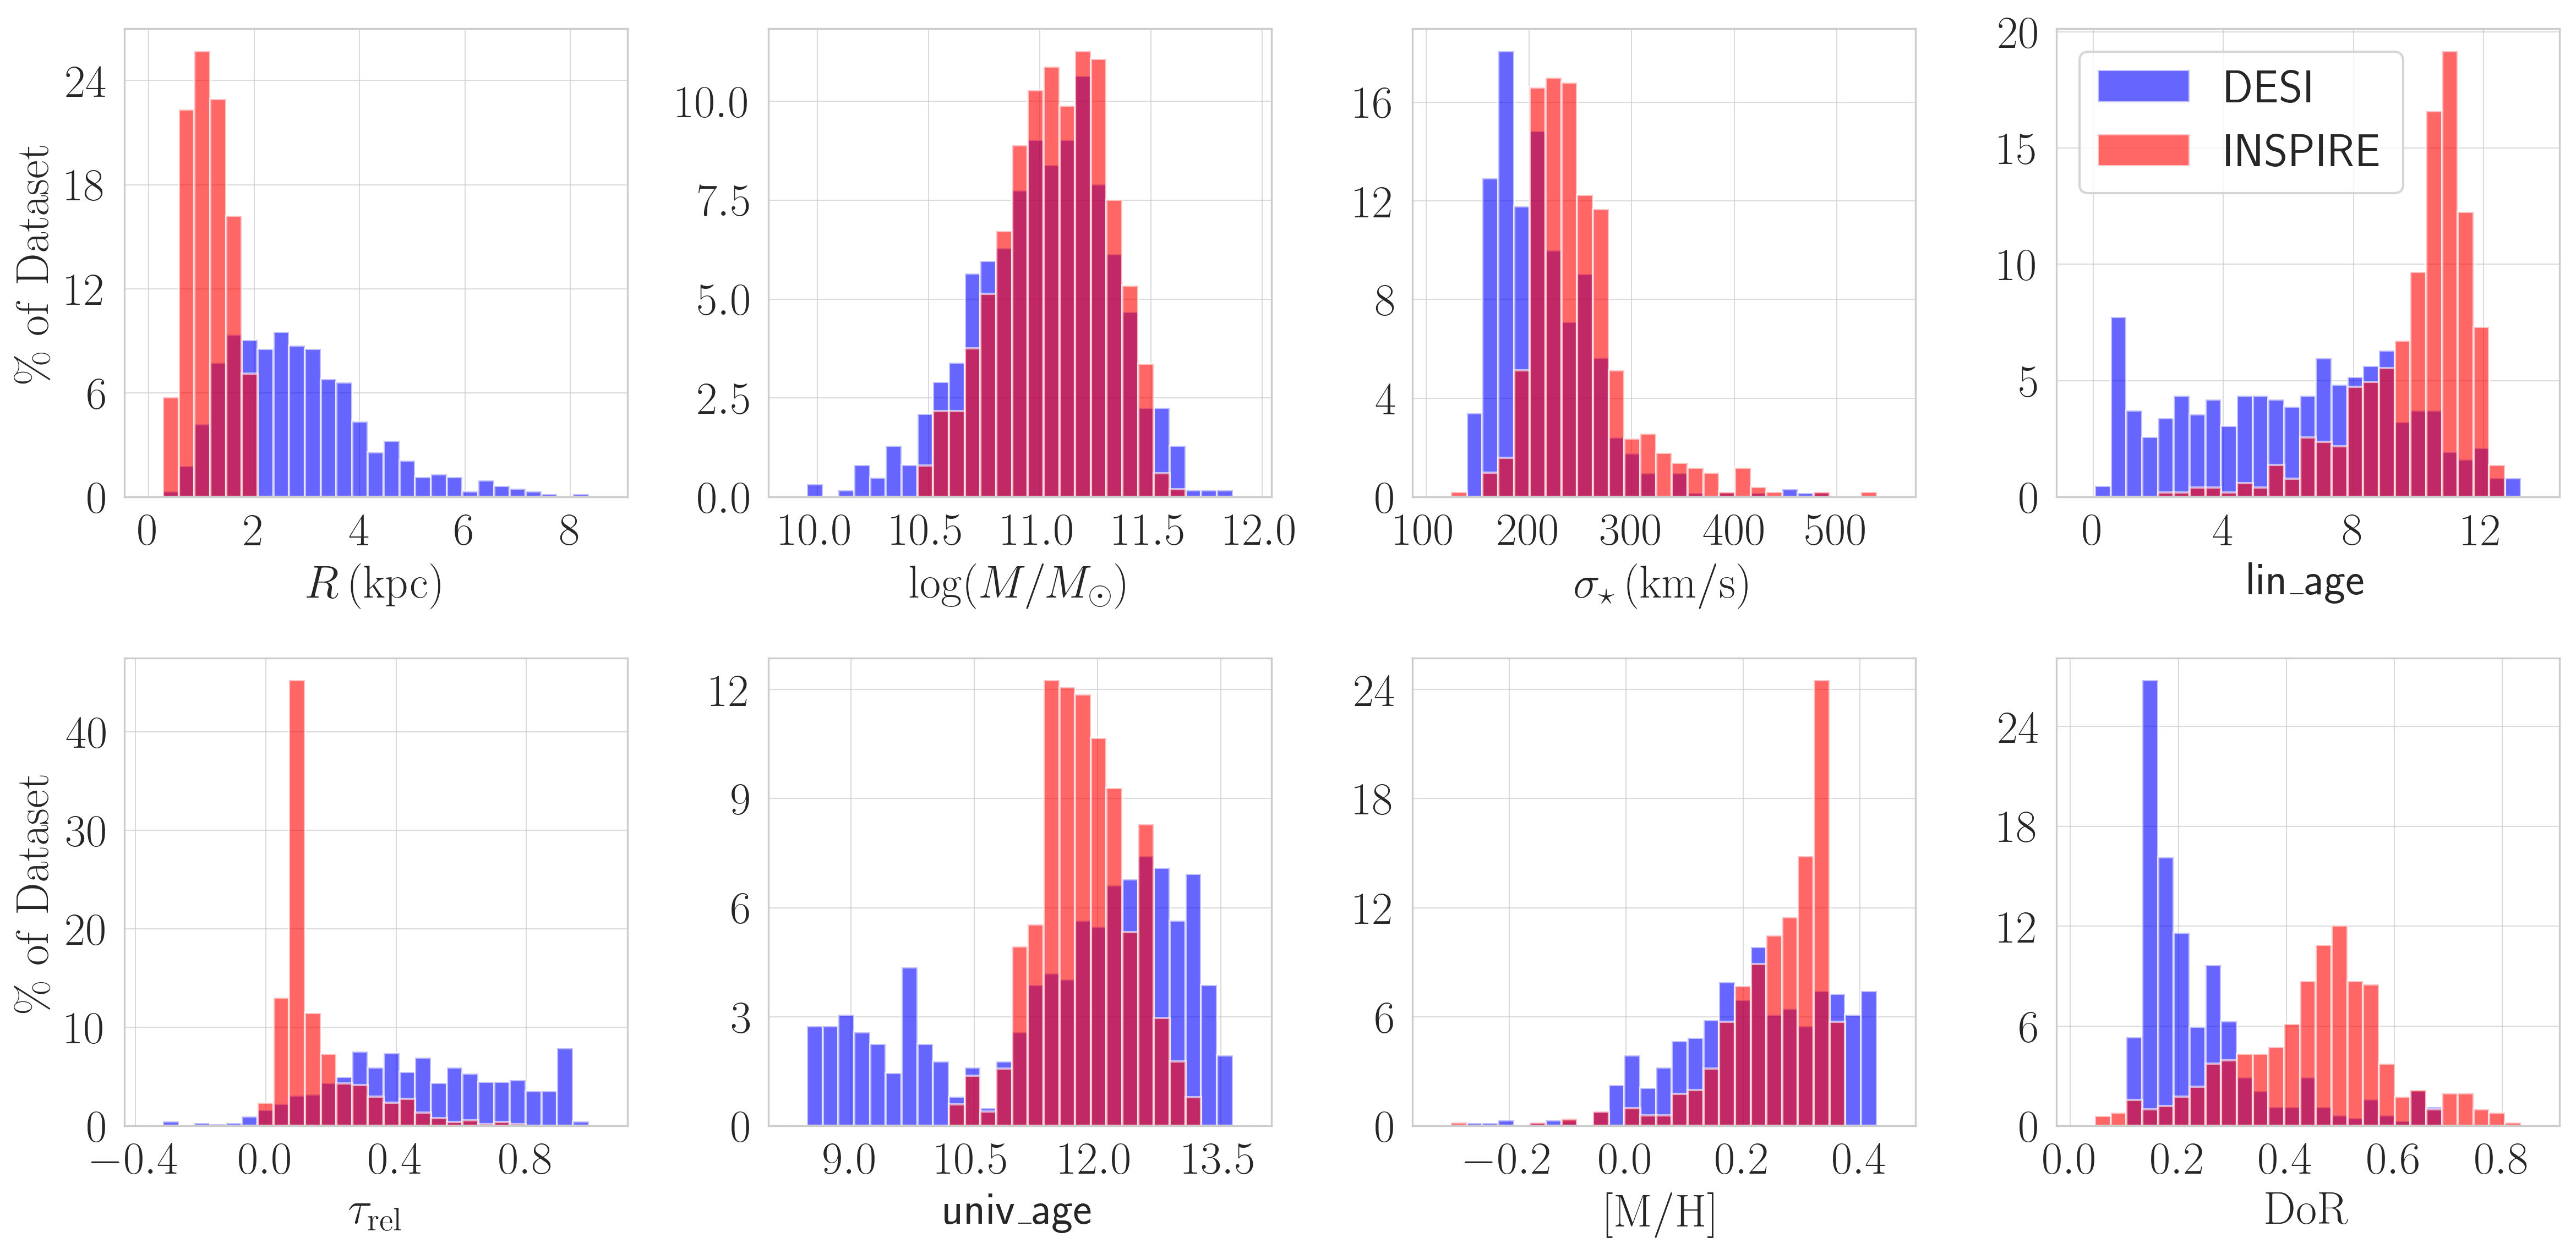

Feature Distribution Comparison Summary:
--------------------------------------------------------------------------------
Feature              INSPIRE Mean    DESI Mean Scale Factor  INSPIRE Std     DESI Std
--------------------------------------------------------------------------------
rad_kpc                    1.1424       2.8438         2.49       0.3967       1.3381
logM                      11.0708      11.0194         1.00       0.2309       0.3031
vdisp                    249.4001     212.9927         0.85      49.1361      47.4935
lin_age                    9.9109       6.1019         0.62       1.7372       3.2703
tau                        0.1551       0.4817         3.11       0.1284       0.2701
univ_age                  11.8443      11.5648         0.98       0.5534       1.4355
met                        0.2600       0.2253         0.87       0.0872       0.1287
DoR                        0.4500       0.2418         0.54       0.1439       0.1272


In [97]:
plot_histograms=True
# desi_df = prepare_desi_data()
if plot_histograms:
    
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    
    # Set LaTeX rendering for text
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 20,
    })
    
    # Combine train and test data
    combined_inspire_df = pd.concat([train_df, test_df], ignore_index=True)
    
    columns = ['rad_kpc', 'logM', 'vdisp', 'lin_age', 'tau', 'univ_age', 'met', 'DoR']
    
    # Dictionary to map feature names to nicer display names
    feature_names = {
        'met': r'$\mathrm{[M/H]}$',
        'tau': r'$\mathrm{\tau_{\rm rel}}$',
        'met_err': r'$\Delta{\mathrm{[M/H]}}$',
        'lin_age_err': r'$\Delta{\mathrm{Age}}$',
        'logM': r'$\log(M/M_{\odot})$',
        'rad_kpc': r'$R \, \mathrm{(kpc)}$',
        'MgFe': r'$\mathrm{[Mg/Fe]}$',
        'vdisp': r'$\sigma_{\star} \, \mathrm{(km/s)}$',
        'DoR': r'$\mathrm{DoR}$'
    }
    
    # Default to original name if not in dictionary
    def get_display_name(feature):
        return feature_names.get(feature, feature)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()  
    
    sns.set_style("whitegrid")
    for i, feature in enumerate(columns):
        if i >= len(axes):  # Skip if we run out of subplots
            break
            
        ax = axes[i]
        
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # 5 major ticks on x-axis
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))  # 5 major ticks on y-axis
        ax.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)

        min_val = min(combined_inspire_df[feature].min(), desi_df[feature].min())
        max_val = max(combined_inspire_df[feature].max(), desi_df[feature].max())
        
        bins = np.linspace(min_val - 0.05 * (max_val - min_val), 
                           max_val + 0.05 * (max_val - min_val), 
                           30)
        
        # Calculate counts for scaling
        inspire_count = len(combined_inspire_df)
        desi_count = len(desi_df)
        
        # Normalize by dataset size (manual percentage calculation)
        inspire_hist, bin_edges = np.histogram(combined_inspire_df[feature], bins=bins)
        desi_hist, _ = np.histogram(desi_df[feature], bins=bins)
        
        # Convert to percentage of dataset
        inspire_hist = inspire_hist / inspire_count * 100
        desi_hist = desi_hist / desi_count * 100
        
        # Plot with the normalized values - DESI in blue, INSPIRE in red
        ax.bar(bin_edges[:-1], desi_hist, width=np.diff(bin_edges), 
               align='edge', alpha=0.6, label='DESI', color='blue')
        ax.bar(bin_edges[:-1], inspire_hist, width=np.diff(bin_edges), 
               align='edge', alpha=0.6, label='INSPIRE', color='red')
        
        inspire_mean = combined_inspire_df[feature].mean()
        inspire_std = combined_inspire_df[feature].std()
        desi_mean = desi_df[feature].mean()
        desi_std = desi_df[feature].std()
        
        # Add titles and labels using the display name dictionary
        ax.set_xlabel(get_display_name(feature))
        if i==0 or i==4:
            ax.set_ylabel(r"$\mathrm{\%\ of\ Dataset}$")

        if i==3:
            ax.legend()
    
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig("../outputs/tests/desi_inspire_comparison_histo.pdf", dpi=300)
    plt.show()
    
    print("Feature Distribution Comparison Summary:")
    print("-" * 80)
    print(f"{'Feature':<20} {'INSPIRE Mean':>12} {'DESI Mean':>12} {'Scale Factor':>12} {'INSPIRE Std':>12} {'DESI Std':>12}")
    print("-" * 80)
    
    for feature in columns:
        inspire_mean = combined_inspire_df[feature].mean()
        inspire_std = combined_inspire_df[feature].std()
        desi_mean = desi_df[feature].mean()
        desi_std = desi_df[feature].std()
        
        scale_factor = desi_mean / inspire_mean if abs(inspire_mean) > 1e-6 else "N/A"
        if isinstance(scale_factor, float):
            scale_factor = f"{scale_factor:.2f}"
        print(f"{feature:<20} {inspire_mean:>12.4f} {desi_mean:>12.4f} {scale_factor:>12} {inspire_std:>12.4f} {desi_std:>12.4f}")
    

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def create_corner_plots(df, features, feature_display_names=None, target='DoR', target_display_name=None):

    # Set LaTeX style to match the original code
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 20,
    })
    
    # Create display names dictionary if not provided
    if feature_display_names is None:
        feature_display_names = {f: f for f in features}
    
    # Set target display name if not provided
    if target_display_name is None:
        target_display_name = target
    
    # Create the first version with the target included as a feature
    # plot_features_with_target(df, features, feature_display_names, target, target_display_name)
    
    # Create the second version without the target but colored by the target
    plot_features_colored_by_target(df, features, feature_display_names, target, target_display_name)

def plot_features_with_target(df, features, feature_display_names, target='DoR', target_display_name=None):
    """Create a corner plot with all features including the target"""
    # Create a new figure
    fig = plt.figure(figsize=(16, 16))
    
    # If target display name not provided, use the target name
    if target_display_name is None:
        target_display_name = target
    
    # Include target in the feature list for this plot
    all_vars = features.copy()
    all_display_names = feature_display_names.copy()
    
    if target not in all_vars:
        all_vars.append(target)
        all_display_names[target] = target_display_name
    
    # Number of variables
    n_vars = len(all_vars)
    
    # Create subplots for each pair of variables
    for i in range(n_vars):
        for j in range(n_vars):
            # Create subplot
            ax = fig.add_subplot(n_vars, n_vars, i * n_vars + j + 1)
            
            if i == j:  # Diagonal: histogram
                # Draw the histogram
                sns.histplot(df[all_vars[i]], kde=True, ax=ax, color='steelblue', 
                            edgecolor='black', linewidth=0.8, alpha=0.7)
                
                # Remove title
                ax.set_title("")
                
                # Add "Count" as a title above the plot instead of as a y-label
                # ax.set_title("Count", fontsize=20, pad=10)
                
                # Remove x-label for diagonal histograms
                ax.set_xlabel("")
                
                # Only set x-label for the bottom row
                if i == n_vars - 1:
                    ax.set_xlabel(all_display_names[all_vars[i]], fontsize=20)
                
                # Remove y-label but keep y-tick labels
                ax.set_ylabel("")
                # Rotate y-ticks 45 degrees for better readability
                ax.tick_params(axis='y', rotation=45)
                
                # If not the bottom row, hide x-tick labels
                if i < n_vars - 1:
                    ax.set_xticklabels([])
                
                ax.grid(True, alpha=0.3)
            
            elif i > j:  # Lower triangle: scatter plots
                scatter = ax.scatter(df[all_vars[j]], df[all_vars[i]], 
                                    s=30, alpha=0.6, 
                                    edgecolors='k', linewidths=0.5)
                
                # Add grid
                ax.grid(True, alpha=0.3)
                
                # Set axis labels only for the bottom row and leftmost column
                # Use display names for labels
                if i == n_vars - 1:
                    ax.set_xlabel(all_display_names[all_vars[j]], fontsize=20)
                else:
                    ax.set_xlabel('')
                    
                if j == 0:
                    ax.set_ylabel(all_display_names[all_vars[i]], fontsize=20)
                else:
                    ax.set_ylabel('')
                
                # Only show tick labels on the edges
                if i < n_vars - 1:  # Not the bottom row
                    ax.set_xticklabels([])
                if j > 0:  # Not the leftmost column
                    ax.set_yticklabels([])
            
            else:  # Upper triangle: leave empty
                ax.axis('off')
            
            # Set ticks inward
            if i != j and i > j:
                ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
                ax.minorticks_on()
    
    # Use larger wspace to increase horizontal spacing between subplots
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.3, hspace=0.1)
    plt.savefig(f'../outputs/tests/corner_plain.pdf')
    
    return fig

def plot_features_colored_by_target(df, features, feature_display_names, target='DoR', target_display_name=None):
    """Create a corner plot with features colored by the target variable"""
    # Create a new figure
    fig = plt.figure(figsize=(16, 16))
    
    # If target display name not provided, use the target name
    if target_display_name is None:
        target_display_name = target
    
    # Number of variables
    n_vars = len(features)
    
    # Create a custom colormap with red for high values (inverted heat colors)
    colors = ["navy", "blue", "dodgerblue", "deepskyblue", "cyan", 
              "yellowgreen", "yellow", "gold", "orange", "orangered", "red", "darkred"]
    cmap = LinearSegmentedColormap.from_list("DoR_cmap", colors) 
    
    # Normalize the target variable for coloring
    norm = plt.Normalize(df[target].min(), df[target].max())
    
    # Create subplots for each pair of variables
    for i in range(n_vars):
        for j in range(n_vars):
            # Create subplot
            ax = fig.add_subplot(n_vars, n_vars, i * n_vars + j + 1)
            
            if i == j:  # Diagonal: histogram

                if features[i] == 'MgFe':
                    mgfe_values = [0.0, 0.1, 0.2, 0.3, 0.4]
                    
                    mgfe_custom_bins = []
                    for value in mgfe_values:
                        mgfe_custom_bins.append(value - 0.005)  # Small buffer below the value
                        mgfe_custom_bins.append(value + 0.005)  # Small buffer above the value
                    
                    mgfe_custom_bins.append(0.405)
                    
                    #mgfe_custom_bins = [max(0, bin_edge) for bin_edge in mgfe_custom_bins]
                    #mgfe_custom_bins = sorted(list(set(mgfe_custom_bins)))
                    
                    counts, bins, patches = ax.hist(df[features[i]], bins=mgfe_custom_bins, alpha=0.7, linewidth=0.8)
                else:
                    counts, bins, patches = ax.hist(df[features[i]], bins=40, alpha=0.7, linewidth=0.8)
                
                
                
                """
                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                for count, x, patch in zip(counts, bin_centers, patches):
                    # Find indices of points in this bin
                    bin_mask = (df[features[i]] >= x - (bins[1]-bins[0])/2) & \
                              (df[features[i]] < x + (bins[1]-bins[0])/2)
                    
                    if any(bin_mask):
                        # Color by average DoR in this bin
                        avg_DoR = df.loc[bin_mask, target].mean()
                        patch.set_facecolor(cmap(norm(avg_DoR)))
                    else:
                        patch.set_facecolor('gray')"""
                    
                for idx, (patch, left_edge, right_edge) in enumerate(zip(patches, bins[:-1], bins[1:])):
                    # For the last bin, include the right edge
                    if idx == len(patches) - 1:
                        bin_mask = (df[features[i]] >= left_edge) & (df[features[i]] <= right_edge)
                    else:
                        bin_mask = (df[features[i]] >= left_edge) & (df[features[i]] < right_edge)
                    
                    if any(bin_mask):
                        avg_DoR = df.loc[bin_mask, target].mean()
                        patch.set_facecolor(cmap(norm(avg_DoR)))
                    else:
                        patch.set_facecolor('gray')
                
                # Add "Count" as a title above the plot instead of as a y-label
                # ax.set_title("Count", fontsize=20, pad=10)
                
                # Remove x-label for diagonal histograms
                ax.set_xlabel("")
                
                # Only set x-label for the bottom row
                if i == n_vars - 1:
                    ax.set_xlabel(feature_display_names[features[i]], fontsize=20)
                
                # Remove y-label but keep y-tick labels
                ax.set_ylabel("")
                # Rotate y-ticks 45 degrees for better readability
                # ax.tick_params(axis='y', rotation=45)
                ax.set_yticklabels([])

                
                # If not the bottom row, hide x-tick labels
                if i < n_vars - 1:
                    ax.set_xticklabels([])
                
                ax.grid(True, alpha=0.3)
            
            elif i > j:  # Lower triangle: scatter plots colored by target
                scatter = ax.scatter(df[features[j]], df[features[i]], 
                                    c=df[target], cmap=cmap, 
                                    s=30, alpha=0.7, linewidths=0.5)
                
                # Add grid
                ax.grid(True, alpha=0.3)
                
                # Set axis labels only for the bottom row and leftmost column
                # Use display names for labels
                if i == n_vars - 1:
                    ax.set_xlabel(feature_display_names[features[j]], fontsize=20)
                else:
                    ax.set_xlabel('')
                    
                if j == 0:
                    ax.set_ylabel(feature_display_names[features[i]], fontsize=20)
                else:
                    ax.set_ylabel('')
                
                # Only show tick labels on the edges
                if i < n_vars - 1:  # Not the bottom row
                    ax.set_xticklabels([])
                if j > 0:  # Not the leftmost column
                    ax.set_yticklabels([])
            
            else:  # Upper triangle: leave empty
                ax.axis('off')
            
            # Set ticks inward
            if i != j and i > j:
                ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
                ax.minorticks_on()
    
    # Add colorbar to the right of the plot
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
    cbar.set_label(target_display_name, rotation=270, fontsize=20, labelpad=20)
    cbar_ax.tick_params(labelsize=12)
    
    # Use larger wspace to increase horizontal spacing between subplots
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.9)
    
    plt.savefig(f'../outputs/tests/corner_dor_coloured.pdf')
    
    return fig

corner = False
if corner:
    target = 'DoR'
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc', 'MgFe', 'vdisp', 'DoR'] # , 'vdisp_err']
    
    # Set a display name for the target variable
    TARGET_DISPLAY_NAME = r'$\mathrm{DoR}$'  # Degree of Rotation
        
    # Create both types of corner plots with custom display names
    create_corner_plots(
        test_df, 
        FEATURES, 
        target=target,
        target_display_name=TARGET_DISPLAY_NAME
    )
    
    create_corner_plots(
        train_df, 
        FEATURES, 
        target=target,
        target_display_name=TARGET_DISPLAY_NAME
    )

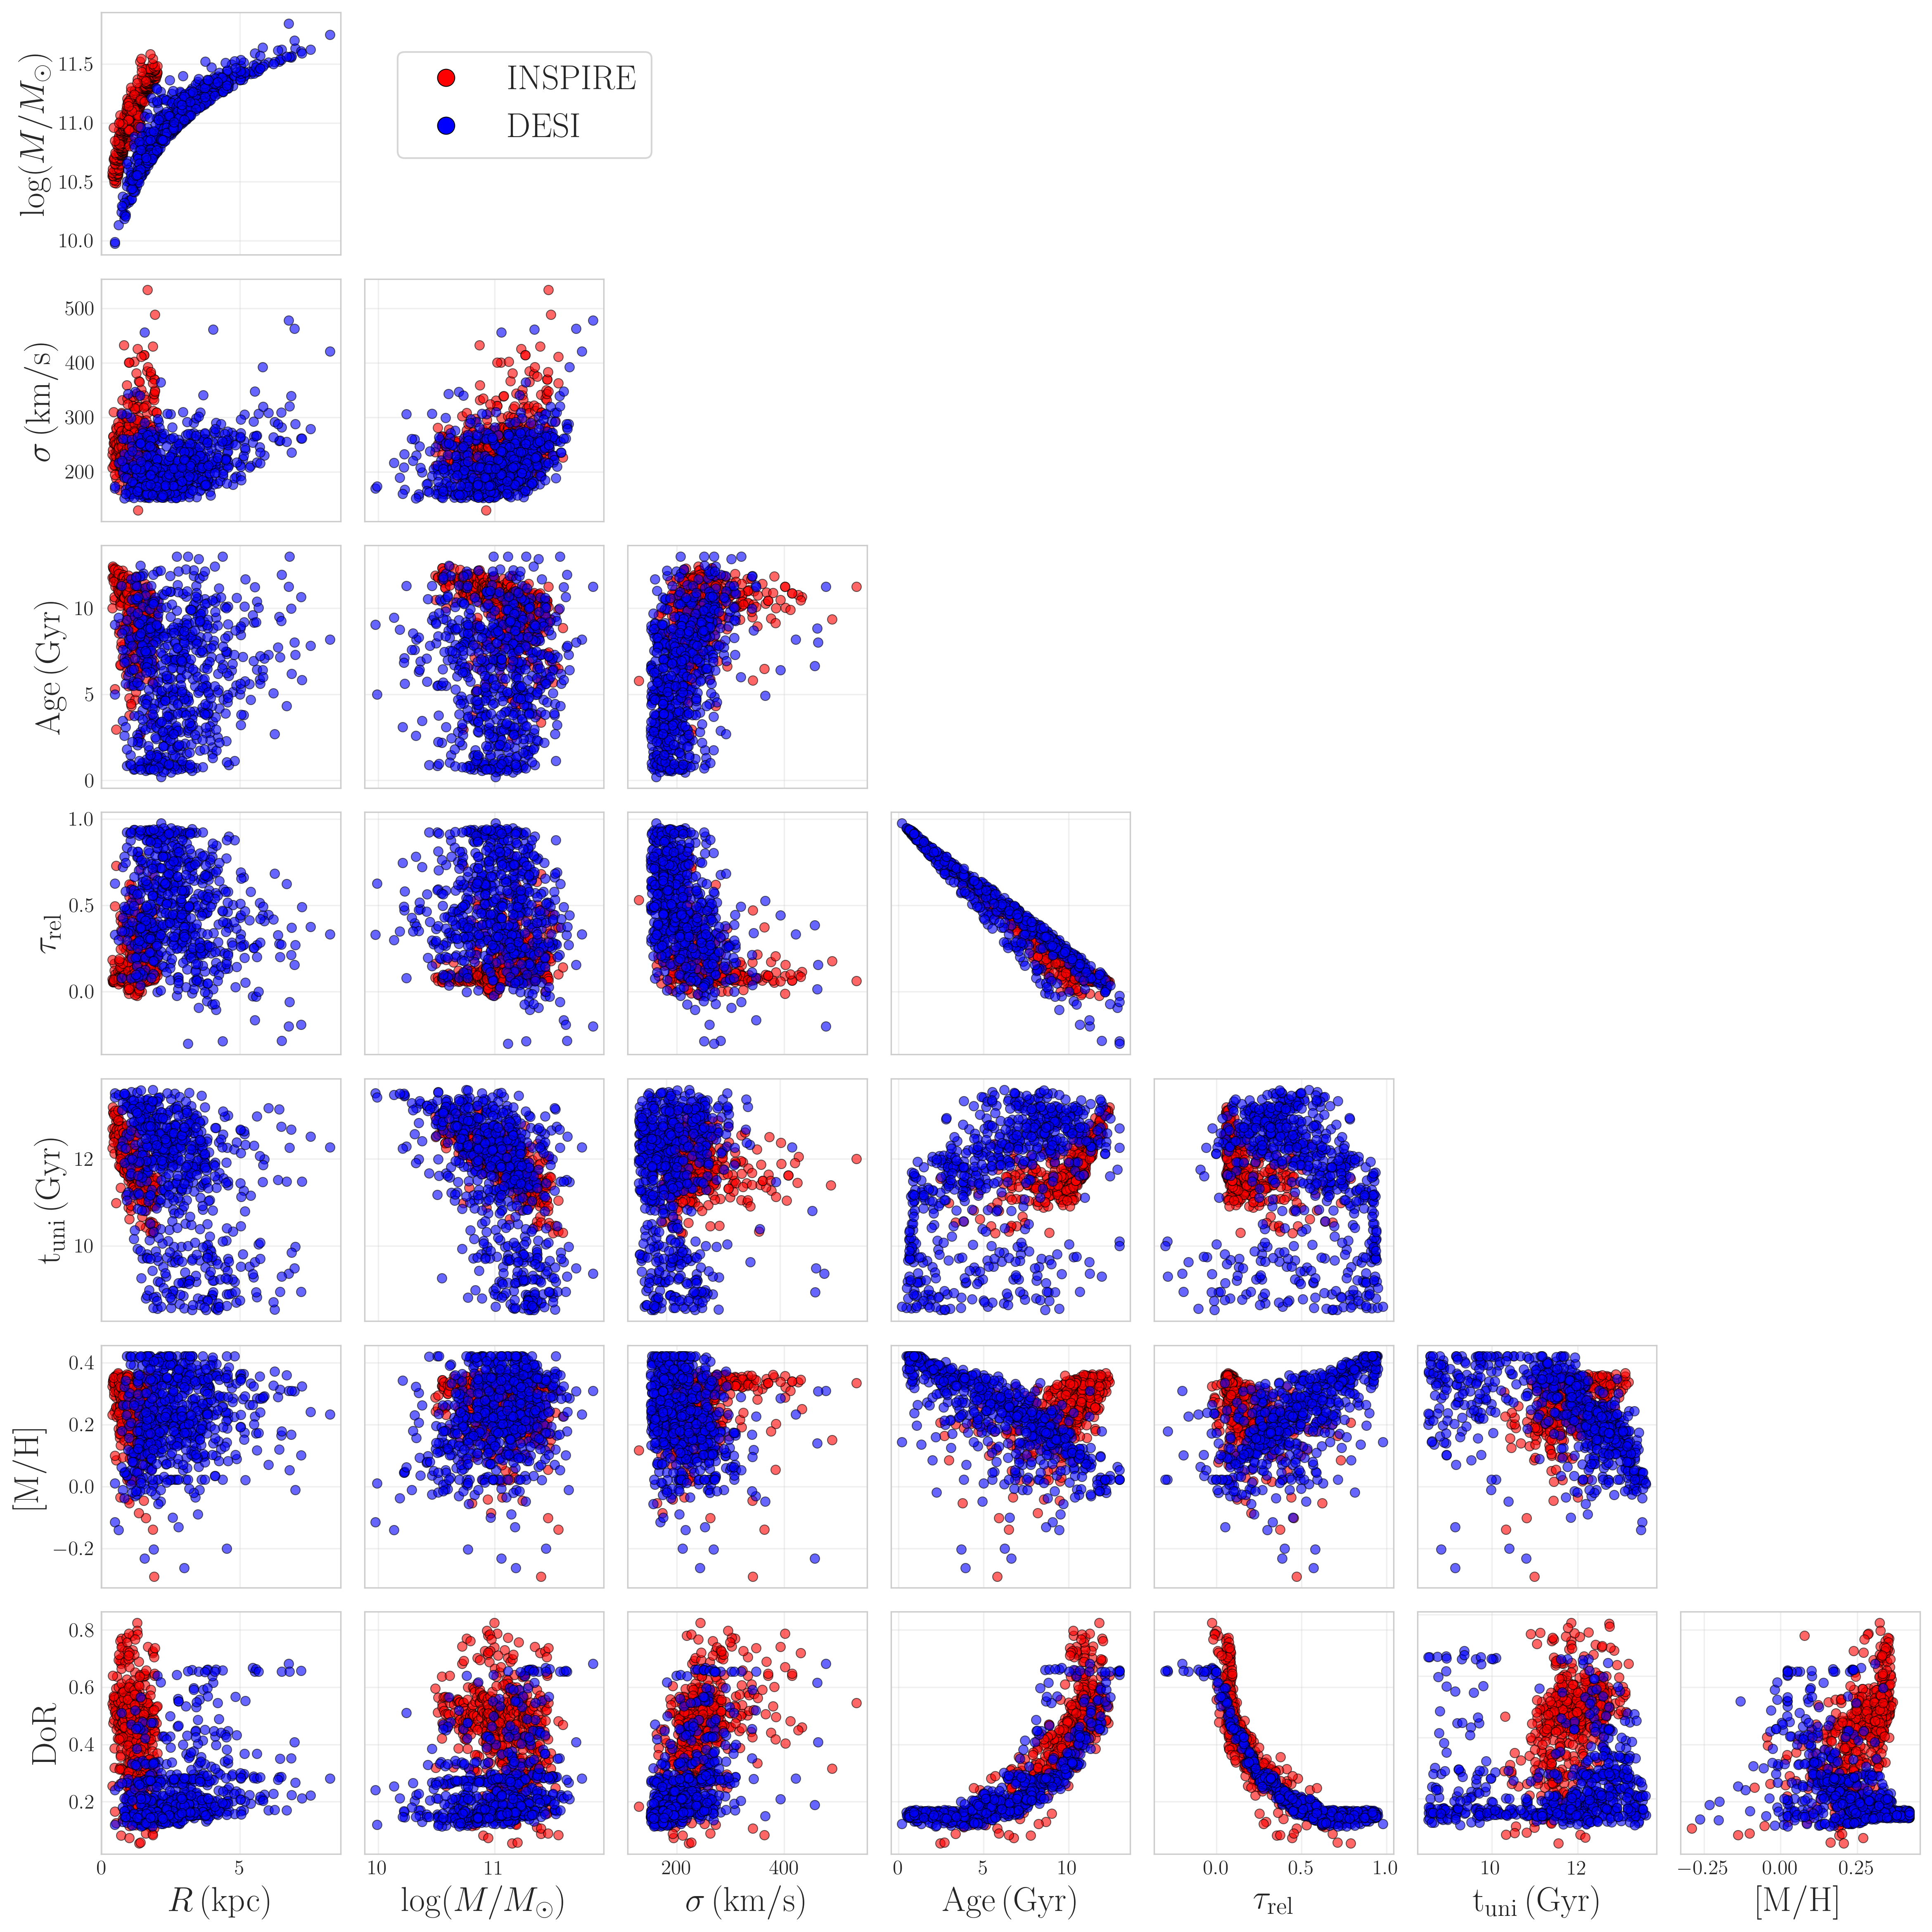

In [103]:
def plot_inspire_vs_desi_corner_with_dor(train_df, test_df, desi_df, features, feature_display_names=None):
    
    # Set LaTeX style to match the original code
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 20,
    })
    
    # Create display names dictionary if not provided
    if feature_display_names is None:
        feature_display_names = {f: f for f in features}
    
    # Number of variables
    n_vars = len(features)
    
    # Create a new figure with a custom GridSpec layout
    fig = plt.figure(figsize=(16, 16))
    
    # Create a GridSpec layout that's n_vars-1 x n_vars-1
    # This completely eliminates space for diagonal elements
    gs = plt.GridSpec(n_vars-1, n_vars-1, figure=fig)
    
    # Combine INSPIRE datasets (train + test) with an identifier column
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()
    desi_df_copy = desi_df.copy()
    
    # Combine train and test into single INSPIRE dataset
    combined_inspire_df = pd.concat([train_df_copy, test_df_copy], ignore_index=True)
    combined_inspire_df['dataset'] = 'INSPIRE'
    
    # For DESI data, we need to handle missing columns
    desi_df_copy['dataset'] = 'DESI'
    
    # Add missing columns to DESI data with NaN values so the plot can handle them
    for feature in features:
        if feature not in desi_df_copy.columns:
            print(f"Warning: {feature} not available in DESI data, filling with NaN")
            desi_df_copy[feature] = np.nan
    
    # Combine INSPIRE and DESI datasets
    combined_df = pd.concat([combined_inspire_df, desi_df_copy], ignore_index=True)
    
    # Define colors for each dataset (matching your histogram colors)
    dataset_colors = {'INSPIRE': 'red', 'DESI': 'blue'}
    
    # Map the feature indices for our compact layout
    # We're using a n_vars-1 x n_vars-1 grid now
    plot_count = 0
    for i in range(1, n_vars):  # Start from 1 to skip first diagonal element
        for j in range(i):      # Only lower triangle
            # Calculate row and column for our compact grid
            row = i - 1  # Adjusted for 0-indexing 
            col = j
            
            # Create subplot at specific position
            ax = fig.add_subplot(gs[row, col])
            plot_count += 1
            
            # Check if both features are available in both datasets
            inspire_subset = combined_df[combined_df['dataset'] == 'INSPIRE']
            desi_subset = combined_df[combined_df['dataset'] == 'DESI']
            
            # Plot INSPIRE data
            inspire_x = inspire_subset[features[j]]
            inspire_y = inspire_subset[features[i]]
            inspire_valid = ~(inspire_x.isna() | inspire_y.isna())
            
            if inspire_valid.any():
                ax.scatter(inspire_x[inspire_valid], inspire_y[inspire_valid], 
                          c='red', label='INSPIRE', 
                          s=30, alpha=0.6, 
                          edgecolors='k', linewidths=0.5)
            
            # Plot DESI data
            desi_x = desi_subset[features[j]]
            desi_y = desi_subset[features[i]]
            desi_valid = ~(desi_x.isna() | desi_y.isna())
            
            if desi_valid.any():
                ax.scatter(desi_x[desi_valid], desi_y[desi_valid], 
                          c='blue', label='DESI', 
                          s=30, alpha=0.6, 
                          edgecolors='k', linewidths=0.5)
            
            # If one or both features are missing from DESI, add a text annotation
            if not desi_valid.any() and features[j] not in desi_df.columns:
                ax.text(0.5, 0.5, f'{features[j]} or {features[i]}\nnot in DESI', 
                       transform=ax.transAxes, ha='center', va='center',
                       fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))
            
            # Add grid
            ax.grid(True, alpha=0.3)
            
            # Set axis labels only for the bottom row and leftmost column
            if i == n_vars - 1:  # Bottom row (last feature)
                ax.set_xlabel(feature_display_names[features[j]], fontsize=20)
            else:
                ax.set_xlabel('')
                
            if j == 0:  # Leftmost column
                ax.set_ylabel(feature_display_names[features[i]], fontsize=20)
            else:
                ax.set_ylabel('')
            
            # Only show tick labels on the edges
            if i < n_vars - 1:  # Not the bottom row
                ax.set_xticklabels([])
            if j > 0:  # Not the leftmost column
                ax.set_yticklabels([])
            
            # Set ticks inward
            ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
            ax.minorticks_on()
    
    # Add a legend to the figure (matching your histogram colors)
    handles, labels = [], []
    for dataset, color in dataset_colors.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color, markersize=10, 
                                 markeredgecolor='k', markeredgewidth=0.5))
        labels.append(dataset)
    
    # Place legend in the top right corner of the figure
    fig.legend(handles, labels, loc='upper right', fontsize=20, 
               bbox_to_anchor=(0.35, 0.97), frameon=True)
    
    # Tighten layout
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    
    plt.savefig('../outputs/tests/inspire_vs_desi_corner_with_dor.pdf')
    plt.savefig('../outputs/tests/inspire_vs_desi_corner_with_dor.png')

    return fig

# Example usage with all your requested columns:
corner_with_dor = True
if corner_with_dor:
    # Your requested columns
    columns = ['rad_kpc', 'logM', 'vdisp', 'lin_age', 'tau', 'univ_age', 'met', 'DoR']
    
    FEATURE_DISPLAY_NAMES = {
        'met': r'$\mathrm{[M/H]}$',
        'tau': r'$\mathrm{\tau_{\rm rel}}$',
        'logM': r'$\log(M/M_{\odot})$',
        'rad_kpc': r'$R \, \mathrm{(kpc)}$',
        'vdisp': r'$\sigma \, \mathrm{(km/s)}$',
        'lin_age': r'$\mathrm{Age \, (Gyr)}$',
        'univ_age': r'$\mathrm{t_{uni} \, (Gyr)}$',
        'DoR': r'$\mathrm{DoR}$'
    }
    
    # Call the new function with DESI data included
    plot_inspire_vs_desi_corner_with_dor(
        train_df, 
        test_df, 
        desi_df,  # Your DESI dataframe
        columns,  # All the columns you requested
        feature_display_names=FEATURE_DISPLAY_NAMES
    )